### TFG AÑO- Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de año a año (252 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testAño.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testAño.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testAño.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testAño.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



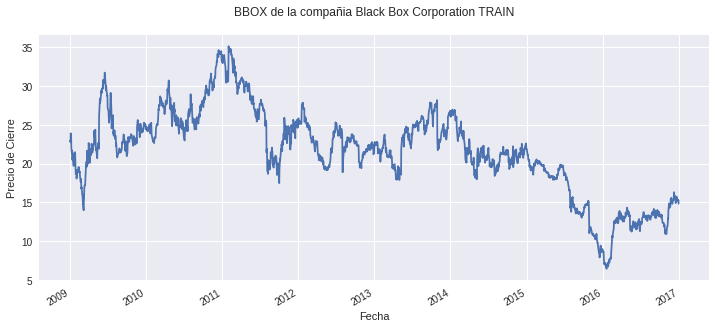

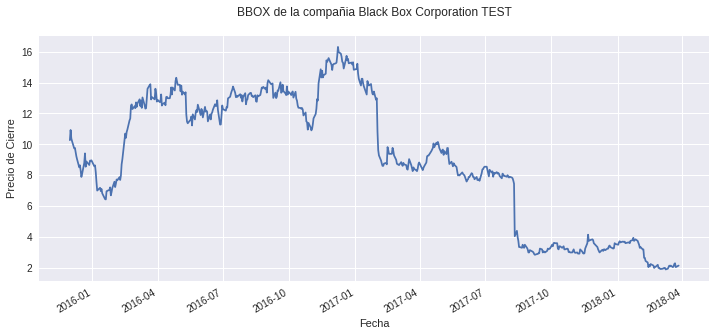

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 5
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [7]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo BBOX de la compañia Black Box Corporation


In [9]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

# Creacion de la red neural LSTM

In [17]:
model42 = Sequential()
model42.add(LSTM(4, input_shape=(252,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 4)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 15s 418ms/step - loss: 492.9026 - porcentaje_margen: 0.0000e+00 - val_loss: 481.1376 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 14s 373ms/step - loss: 471.4673 - porcentaje_margen: 0.0000e+00 - val_loss: 462.7560 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [==================

Epoch 92/1500
37/37 [==============================] - 12s 325ms/step - loss: 136.8614 - porcentaje_margen: 0.0253 - val_loss: 135.9522 - val_porcentaje_margen: 0.0197
Epoch 93/1500
37/37 [==============================] - 12s 321ms/step - loss: 135.0411 - porcentaje_margen: 0.0270 - val_loss: 134.1118 - val_porcentaje_margen: 0.0214
Epoch 94/1500
37/37 [==============================] - 12s 325ms/step - loss: 133.2272 - porcentaje_margen: 0.0279 - val_loss: 132.3131 - val_porcentaje_margen: 0.0214
Epoch 95/1500
37/37 [==============================] - 12s 327ms/step - loss: 131.4414 - porcentaje_margen: 0.0312 - val_loss: 130.5327 - val_porcentaje_margen: 0.0181
Epoch 96/1500
37/37 [==============================] - 12s 326ms/step - loss: 129.6939 - porcentaje_margen: 0.0304 - val_loss: 128.7900 - val_porcentaje_margen: 0.0230
Epoch 97/1500
37/37 [==============================] - 12s 322ms/step - loss: 127.9725 - porcentaje_margen: 0.0304 - val_loss: 127.0622 - val_porcentaje_margen:

Epoch 141/1500
37/37 [==============================] - 12s 318ms/step - loss: 70.0025 - porcentaje_margen: 0.0287 - val_loss: 69.2036 - val_porcentaje_margen: 0.0247
Epoch 142/1500
37/37 [==============================] - 12s 325ms/step - loss: 69.0728 - porcentaje_margen: 0.0228 - val_loss: 68.2693 - val_porcentaje_margen: 0.0214
Epoch 143/1500
37/37 [==============================] - 12s 321ms/step - loss: 68.1610 - porcentaje_margen: 0.0220 - val_loss: 67.3630 - val_porcentaje_margen: 0.0197
Epoch 144/1500
37/37 [==============================] - 12s 328ms/step - loss: 67.2668 - porcentaje_margen: 0.0186 - val_loss: 66.4645 - val_porcentaje_margen: 0.0164
Epoch 145/1500
37/37 [==============================] - 12s 323ms/step - loss: 66.3717 - porcentaje_margen: 0.0194 - val_loss: 65.5738 - val_porcentaje_margen: 0.0164
Epoch 146/1500
37/37 [==============================] - 12s 325ms/step - loss: 65.5054 - porcentaje_margen: 0.0194 - val_loss: 64.7004 - val_porcentaje_margen: 0.018

37/37 [==============================] - 12s 333ms/step - loss: 32.2878 - porcentaje_margen: 0.1900 - val_loss: 31.5595 - val_porcentaje_margen: 0.1931
Epoch 191/1500
37/37 [==============================] - 12s 327ms/step - loss: 31.6278 - porcentaje_margen: 0.1900 - val_loss: 32.0240 - val_porcentaje_margen: 0.2079
Epoch 192/1500
37/37 [==============================] - 12s 330ms/step - loss: 31.1055 - porcentaje_margen: 0.1959 - val_loss: 30.4547 - val_porcentaje_margen: 0.2030
Epoch 193/1500
37/37 [==============================] - 12s 328ms/step - loss: 30.0464 - porcentaje_margen: 0.2010 - val_loss: 29.5626 - val_porcentaje_margen: 0.2079
Epoch 194/1500
37/37 [==============================] - 12s 337ms/step - loss: 29.3545 - porcentaje_margen: 0.1816 - val_loss: 29.1779 - val_porcentaje_margen: 0.1980
Epoch 195/1500
37/37 [==============================] - 12s 337ms/step - loss: 28.7685 - porcentaje_margen: 0.1867 - val_loss: 28.2173 - val_porcentaje_margen: 0.2128
Epoch 196/150

37/37 [==============================] - 13s 340ms/step - loss: 5.3294 - porcentaje_margen: 0.5988 - val_loss: 5.2996 - val_porcentaje_margen: 0.5401
Epoch 289/1500
37/37 [==============================] - 13s 343ms/step - loss: 5.2625 - porcentaje_margen: 0.5760 - val_loss: 5.2538 - val_porcentaje_margen: 0.5444
Epoch 290/1500
37/37 [==============================] - 13s 345ms/step - loss: 5.2230 - porcentaje_margen: 0.5752 - val_loss: 5.1798 - val_porcentaje_margen: 0.5352
Epoch 291/1500
37/37 [==============================] - 12s 324ms/step - loss: 5.1256 - porcentaje_margen: 0.5878 - val_loss: 5.0717 - val_porcentaje_margen: 0.5434
Epoch 292/1500
37/37 [==============================] - 12s 332ms/step - loss: 5.0405 - porcentaje_margen: 0.5980 - val_loss: 4.9750 - val_porcentaje_margen: 0.5467
Epoch 293/1500
37/37 [==============================] - 12s 331ms/step - loss: 4.9516 - porcentaje_margen: 0.5861 - val_loss: 4.9577 - val_porcentaje_margen: 0.5559
Epoch 294/1500
37/37 [===

Epoch 338/1500
37/37 [==============================] - 12s 328ms/step - loss: 2.6342 - porcentaje_margen: 0.6453 - val_loss: 2.5756 - val_porcentaje_margen: 0.6533
Epoch 339/1500
37/37 [==============================] - 12s 327ms/step - loss: 2.5977 - porcentaje_margen: 0.6579 - val_loss: 2.5527 - val_porcentaje_margen: 0.6592
Epoch 340/1500
37/37 [==============================] - 12s 331ms/step - loss: 2.5754 - porcentaje_margen: 0.6605 - val_loss: 2.5312 - val_porcentaje_margen: 0.6263
Epoch 341/1500
37/37 [==============================] - 12s 323ms/step - loss: 2.6039 - porcentaje_margen: 0.6318 - val_loss: 2.5014 - val_porcentaje_margen: 0.6648
Epoch 342/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.5154 - porcentaje_margen: 0.6613 - val_loss: 2.4841 - val_porcentaje_margen: 0.6543
Epoch 343/1500
37/37 [==============================] - 12s 325ms/step - loss: 2.4626 - porcentaje_margen: 0.6613 - val_loss: 2.4328 - val_porcentaje_margen: 0.6549
Epoch 344/

Epoch 388/1500
37/37 [==============================] - 12s 324ms/step - loss: 1.4928 - porcentaje_margen: 0.7103 - val_loss: 1.5002 - val_porcentaje_margen: 0.6878
Epoch 389/1500
37/37 [==============================] - 12s 325ms/step - loss: 1.5289 - porcentaje_margen: 0.7196 - val_loss: 1.4637 - val_porcentaje_margen: 0.7059
Epoch 390/1500
37/37 [==============================] - 12s 327ms/step - loss: 1.4699 - porcentaje_margen: 0.7137 - val_loss: 1.4320 - val_porcentaje_margen: 0.7076
Epoch 391/1500
37/37 [==============================] - 12s 325ms/step - loss: 1.4544 - porcentaje_margen: 0.7154 - val_loss: 1.4192 - val_porcentaje_margen: 0.7207
Epoch 392/1500
37/37 [==============================] - 12s 329ms/step - loss: 1.4187 - porcentaje_margen: 0.7280 - val_loss: 1.4103 - val_porcentaje_margen: 0.7174
Epoch 393/1500
37/37 [==============================] - 12s 320ms/step - loss: 1.4186 - porcentaje_margen: 0.7331 - val_loss: 1.4037 - val_porcentaje_margen: 0.7109
Epoch 394/

Epoch 438/1500
37/37 [==============================] - 12s 325ms/step - loss: 1.0607 - porcentaje_margen: 0.7517 - val_loss: 1.0701 - val_porcentaje_margen: 0.7306
Epoch 439/1500
37/37 [==============================] - 12s 319ms/step - loss: 1.0663 - porcentaje_margen: 0.7466 - val_loss: 1.2066 - val_porcentaje_margen: 0.6763
Epoch 440/1500
37/37 [==============================] - 12s 323ms/step - loss: 1.0809 - porcentaje_margen: 0.7432 - val_loss: 1.0621 - val_porcentaje_margen: 0.7306
Epoch 441/1500
37/37 [==============================] - 12s 327ms/step - loss: 1.0524 - porcentaje_margen: 0.7483 - val_loss: 1.0679 - val_porcentaje_margen: 0.7289
Epoch 442/1500
37/37 [==============================] - 12s 326ms/step - loss: 1.0671 - porcentaje_margen: 0.7551 - val_loss: 1.0659 - val_porcentaje_margen: 0.7306
Epoch 443/1500
37/37 [==============================] - 12s 324ms/step - loss: 1.0552 - porcentaje_margen: 0.7618 - val_loss: 1.0635 - val_porcentaje_margen: 0.7372
Epoch 444/

Epoch 488/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.9442 - porcentaje_margen: 0.7711 - val_loss: 0.9928 - val_porcentaje_margen: 0.7355
Epoch 489/1500
37/37 [==============================] - 12s 314ms/step - loss: 0.9632 - porcentaje_margen: 0.7551 - val_loss: 0.9614 - val_porcentaje_margen: 0.7372
Epoch 490/1500
37/37 [==============================] - 12s 333ms/step - loss: 0.9333 - porcentaje_margen: 0.7610 - val_loss: 1.0105 - val_porcentaje_margen: 0.7339
Epoch 491/1500
37/37 [==============================] - 12s 327ms/step - loss: 1.0015 - porcentaje_margen: 0.7297 - val_loss: 1.0531 - val_porcentaje_margen: 0.7158
Epoch 492/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.9346 - porcentaje_margen: 0.7753 - val_loss: 0.9461 - val_porcentaje_margen: 0.7438
Epoch 493/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.9346 - porcentaje_margen: 0.7627 - val_loss: 0.9894 - val_porcentaje_margen: 0.7289
Epoch 494/

Epoch 538/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.8776 - porcentaje_margen: 0.7905 - val_loss: 0.9233 - val_porcentaje_margen: 0.7553
Epoch 539/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.8915 - porcentaje_margen: 0.7905 - val_loss: 0.8947 - val_porcentaje_margen: 0.7569
Epoch 540/1500
37/37 [==============================] - 12s 334ms/step - loss: 0.9077 - porcentaje_margen: 0.7736 - val_loss: 0.8781 - val_porcentaje_margen: 0.7651
Epoch 541/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.8894 - porcentaje_margen: 0.7846 - val_loss: 0.8772 - val_porcentaje_margen: 0.7717
Epoch 542/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.8745 - porcentaje_margen: 0.7880 - val_loss: 0.8744 - val_porcentaje_margen: 0.7602
Epoch 543/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.8878 - porcentaje_margen: 0.7635 - val_loss: 0.8777 - val_porcentaje_margen: 0.7586
Epoch 544/

Epoch 588/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.8321 - porcentaje_margen: 0.7880 - val_loss: 0.8358 - val_porcentaje_margen: 0.7832
Epoch 589/1500
37/37 [==============================] - 12s 329ms/step - loss: 0.8385 - porcentaje_margen: 0.7939 - val_loss: 0.8307 - val_porcentaje_margen: 0.7816
Epoch 590/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.8571 - porcentaje_margen: 0.7956 - val_loss: 0.8289 - val_porcentaje_margen: 0.7651
Epoch 591/1500
37/37 [==============================] - 12s 329ms/step - loss: 0.8415 - porcentaje_margen: 0.7914 - val_loss: 0.8262 - val_porcentaje_margen: 0.7717
Epoch 592/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.8346 - porcentaje_margen: 0.7829 - val_loss: 0.8393 - val_porcentaje_margen: 0.7602
Epoch 593/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.8311 - porcentaje_margen: 0.7939 - val_loss: 0.8449 - val_porcentaje_margen: 0.7569
Epoch 594/

Epoch 638/1500
37/37 [==============================] - 12s 332ms/step - loss: 0.8106 - porcentaje_margen: 0.8057 - val_loss: 0.8036 - val_porcentaje_margen: 0.7750
Epoch 639/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.8362 - porcentaje_margen: 0.7812 - val_loss: 0.8005 - val_porcentaje_margen: 0.7734
Epoch 640/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.8657 - porcentaje_margen: 0.7846 - val_loss: 0.8138 - val_porcentaje_margen: 0.7684
Epoch 641/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.8360 - porcentaje_margen: 0.7914 - val_loss: 0.7941 - val_porcentaje_margen: 0.7832
Epoch 642/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.8063 - porcentaje_margen: 0.7998 - val_loss: 0.8111 - val_porcentaje_margen: 0.7882
Epoch 643/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.8156 - porcentaje_margen: 0.7990 - val_loss: 0.7945 - val_porcentaje_margen: 0.7816
Epoch 644/

Epoch 688/1500
37/37 [==============================] - 12s 328ms/step - loss: 0.7723 - porcentaje_margen: 0.8133 - val_loss: 0.7996 - val_porcentaje_margen: 0.7734
Epoch 689/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.7725 - porcentaje_margen: 0.8176 - val_loss: 0.7747 - val_porcentaje_margen: 0.7849
Epoch 690/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.7671 - porcentaje_margen: 0.8057 - val_loss: 0.7985 - val_porcentaje_margen: 0.7766
Epoch 691/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.7630 - porcentaje_margen: 0.8100 - val_loss: 0.7810 - val_porcentaje_margen: 0.7734
Epoch 692/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.7768 - porcentaje_margen: 0.8159 - val_loss: 0.7794 - val_porcentaje_margen: 0.7987
Epoch 693/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.7942 - porcentaje_margen: 0.8049 - val_loss: 0.7749 - val_porcentaje_margen: 0.7987
Epoch 694/

Epoch 738/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.7625 - porcentaje_margen: 0.8108 - val_loss: 0.7714 - val_porcentaje_margen: 0.7937
Epoch 739/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.7329 - porcentaje_margen: 0.8243 - val_loss: 0.7783 - val_porcentaje_margen: 0.7954
Epoch 740/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.7633 - porcentaje_margen: 0.8108 - val_loss: 0.7850 - val_porcentaje_margen: 0.7937
Epoch 741/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.7327 - porcentaje_margen: 0.8142 - val_loss: 0.7685 - val_porcentaje_margen: 0.7970
Epoch 742/1500
37/37 [==============================] - 12s 330ms/step - loss: 0.7436 - porcentaje_margen: 0.8226 - val_loss: 0.7729 - val_porcentaje_margen: 0.7987
Epoch 743/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.7231 - porcentaje_margen: 0.8345 - val_loss: 0.8722 - val_porcentaje_margen: 0.7740
Epoch 744/

Epoch 788/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.7258 - porcentaje_margen: 0.8345 - val_loss: 0.7600 - val_porcentaje_margen: 0.7816
Epoch 789/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.7059 - porcentaje_margen: 0.8336 - val_loss: 0.7668 - val_porcentaje_margen: 0.7987
Epoch 790/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.7018 - porcentaje_margen: 0.8361 - val_loss: 0.7679 - val_porcentaje_margen: 0.8036
Epoch 791/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.7107 - porcentaje_margen: 0.8184 - val_loss: 0.7721 - val_porcentaje_margen: 0.7954
Epoch 792/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.7187 - porcentaje_margen: 0.8328 - val_loss: 0.8006 - val_porcentaje_margen: 0.7773
Epoch 793/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.7259 - porcentaje_margen: 0.8193 - val_loss: 0.7794 - val_porcentaje_margen: 0.7882
Epoch 794/

Epoch 838/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.6962 - porcentaje_margen: 0.8387 - val_loss: 0.7761 - val_porcentaje_margen: 0.7921
Epoch 839/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.7228 - porcentaje_margen: 0.8218 - val_loss: 0.7940 - val_porcentaje_margen: 0.7898
Epoch 840/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.6869 - porcentaje_margen: 0.8412 - val_loss: 0.7500 - val_porcentaje_margen: 0.7914
Epoch 841/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.6995 - porcentaje_margen: 0.8395 - val_loss: 0.7774 - val_porcentaje_margen: 0.7937
Epoch 842/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.6836 - porcentaje_margen: 0.8412 - val_loss: 0.7494 - val_porcentaje_margen: 0.7832
Epoch 843/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.7072 - porcentaje_margen: 0.8209 - val_loss: 0.7491 - val_porcentaje_margen: 0.7832
Epoch 844/

Epoch 888/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.6831 - porcentaje_margen: 0.8328 - val_loss: 0.7379 - val_porcentaje_margen: 0.7898
Epoch 889/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6829 - porcentaje_margen: 0.8480 - val_loss: 0.9020 - val_porcentaje_margen: 0.7493
Epoch 890/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.7046 - porcentaje_margen: 0.8252 - val_loss: 0.7361 - val_porcentaje_margen: 0.7980
Epoch 891/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.6845 - porcentaje_margen: 0.8404 - val_loss: 0.7382 - val_porcentaje_margen: 0.7898
Epoch 892/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6956 - porcentaje_margen: 0.8446 - val_loss: 0.7359 - val_porcentaje_margen: 0.7832
Epoch 893/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.6986 - porcentaje_margen: 0.8336 - val_loss: 0.7339 - val_porcentaje_margen: 0.7964
Epoch 894/

Epoch 938/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6736 - porcentaje_margen: 0.8488 - val_loss: 0.7294 - val_porcentaje_margen: 0.7964
Epoch 939/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6828 - porcentaje_margen: 0.8361 - val_loss: 0.7350 - val_porcentaje_margen: 0.7947
Epoch 940/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.6786 - porcentaje_margen: 0.8328 - val_loss: 0.7281 - val_porcentaje_margen: 0.7931
Epoch 941/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6826 - porcentaje_margen: 0.8378 - val_loss: 0.7315 - val_porcentaje_margen: 0.8030
Epoch 942/1500
37/37 [==============================] - 12s 319ms/step - loss: 0.6871 - porcentaje_margen: 0.8378 - val_loss: 0.7540 - val_porcentaje_margen: 0.7931
Epoch 943/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.6879 - porcentaje_margen: 0.8353 - val_loss: 0.7636 - val_porcentaje_margen: 0.7997
Epoch 944/

Epoch 988/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6708 - porcentaje_margen: 0.8395 - val_loss: 0.7615 - val_porcentaje_margen: 0.7987
Epoch 989/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6918 - porcentaje_margen: 0.8235 - val_loss: 0.7331 - val_porcentaje_margen: 0.7997
Epoch 990/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.7013 - porcentaje_margen: 0.8404 - val_loss: 0.7275 - val_porcentaje_margen: 0.7997
Epoch 991/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6780 - porcentaje_margen: 0.8353 - val_loss: 0.7667 - val_porcentaje_margen: 0.8003
Epoch 992/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.6728 - porcentaje_margen: 0.8412 - val_loss: 0.7328 - val_porcentaje_margen: 0.7931
Epoch 993/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6727 - porcentaje_margen: 0.8488 - val_loss: 0.7241 - val_porcentaje_margen: 0.7997
Epoch 994/

37/37 [==============================] - 12s 319ms/step - loss: 0.7174 - porcentaje_margen: 0.8438 - val_loss: 0.7176 - val_porcentaje_margen: 0.8063
Epoch 1087/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.6587 - porcentaje_margen: 0.8395 - val_loss: 0.7261 - val_porcentaje_margen: 0.7964
Epoch 1088/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.6719 - porcentaje_margen: 0.8404 - val_loss: 0.7123 - val_porcentaje_margen: 0.8046
Epoch 1089/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6593 - porcentaje_margen: 0.8530 - val_loss: 0.7764 - val_porcentaje_margen: 0.7888
Epoch 1090/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6766 - porcentaje_margen: 0.8328 - val_loss: 0.7135 - val_porcentaje_margen: 0.8095
Epoch 1091/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6592 - porcentaje_margen: 0.8488 - val_loss: 0.7151 - val_porcentaje_margen: 0.8079
Epoch 1092/1500
37/3

37/37 [==============================] - 12s 327ms/step - loss: 0.6855 - porcentaje_margen: 0.8336 - val_loss: 0.7499 - val_porcentaje_margen: 0.7987
Epoch 1185/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6527 - porcentaje_margen: 0.8454 - val_loss: 0.7110 - val_porcentaje_margen: 0.8112
Epoch 1186/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6600 - porcentaje_margen: 0.8471 - val_loss: 0.7092 - val_porcentaje_margen: 0.8063
Epoch 1187/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.7105 - porcentaje_margen: 0.8311 - val_loss: 0.7974 - val_porcentaje_margen: 0.7839
Epoch 1188/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.6741 - porcentaje_margen: 0.8446 - val_loss: 0.7166 - val_porcentaje_margen: 0.8030
Epoch 1189/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6678 - porcentaje_margen: 0.8438 - val_loss: 0.7113 - val_porcentaje_margen: 0.8112
Epoch 1190/1500
37/3

37/37 [==============================] - 12s 314ms/step - loss: 0.6976 - porcentaje_margen: 0.8328 - val_loss: 0.7531 - val_porcentaje_margen: 0.8020
Epoch 1283/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.6793 - porcentaje_margen: 0.8387 - val_loss: 0.7172 - val_porcentaje_margen: 0.8161
Epoch 1284/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.6551 - porcentaje_margen: 0.8404 - val_loss: 0.7580 - val_porcentaje_margen: 0.7987
Epoch 1285/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6819 - porcentaje_margen: 0.8404 - val_loss: 0.7240 - val_porcentaje_margen: 0.7964
Epoch 1286/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6532 - porcentaje_margen: 0.8522 - val_loss: 0.7606 - val_porcentaje_margen: 0.7937
Epoch 1287/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.6589 - porcentaje_margen: 0.8404 - val_loss: 0.7230 - val_porcentaje_margen: 0.8095
Epoch 1288/1500
37/3

37/37 [==============================] - 12s 316ms/step - loss: 0.6549 - porcentaje_margen: 0.8378 - val_loss: 0.7044 - val_porcentaje_margen: 0.8095
Epoch 1381/1500
37/37 [==============================] - 12s 323ms/step - loss: 0.6652 - porcentaje_margen: 0.8412 - val_loss: 0.8481 - val_porcentaje_margen: 0.7609
Epoch 1382/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.7025 - porcentaje_margen: 0.8294 - val_loss: 0.7308 - val_porcentaje_margen: 0.8095
Epoch 1383/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6784 - porcentaje_margen: 0.8438 - val_loss: 0.7596 - val_porcentaje_margen: 0.7970
Epoch 1384/1500
37/37 [==============================] - 12s 320ms/step - loss: 0.6567 - porcentaje_margen: 0.8404 - val_loss: 0.7073 - val_porcentaje_margen: 0.8112
Epoch 1385/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.6765 - porcentaje_margen: 0.8353 - val_loss: 0.7198 - val_porcentaje_margen: 0.7997
Epoch 1386/1500
37/3

37/37 [==============================] - 12s 323ms/step - loss: 0.6473 - porcentaje_margen: 0.8471 - val_loss: 0.7475 - val_porcentaje_margen: 0.7954
Epoch 1479/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.6705 - porcentaje_margen: 0.8294 - val_loss: 0.7053 - val_porcentaje_margen: 0.7964
Epoch 1480/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.6520 - porcentaje_margen: 0.8378 - val_loss: 0.7015 - val_porcentaje_margen: 0.8046
Epoch 1481/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.6827 - porcentaje_margen: 0.8421 - val_loss: 0.7086 - val_porcentaje_margen: 0.8145
Epoch 1482/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.6564 - porcentaje_margen: 0.8421 - val_loss: 0.7019 - val_porcentaje_margen: 0.8046
Epoch 1483/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.6513 - porcentaje_margen: 0.8446 - val_loss: 0.7110 - val_porcentaje_margen: 0.7947
Epoch 1484/1500
37/3

In [18]:
model84 = Sequential()
model84.add(LSTM(8, input_shape=(252,3),return_sequences=True))
model84.add(LSTM(units = 4,return_sequences = False))
model84.add(Dense(1)) 
model84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model84.summary()
history_84 = model84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 8)            384       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 16s 437ms/step - loss: 482.9495 - porcentaje_margen: 0.0000e+00 - val_loss: 473.1797 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 15s 399ms/step - loss: 458.6985 - porcentaje_margen: 0.0000e+00 - val_loss: 442.9236 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [================

37/37 [==============================] - 14s 391ms/step - loss: 57.3547 - porcentaje_margen: 0.0051 - val_loss: 56.3931 - val_porcentaje_margen: 0.0066
Epoch 94/1500
37/37 [==============================] - 14s 382ms/step - loss: 56.3268 - porcentaje_margen: 0.0059 - val_loss: 55.3786 - val_porcentaje_margen: 0.0049
Epoch 95/1500
37/37 [==============================] - 14s 376ms/step - loss: 55.3440 - porcentaje_margen: 0.0059 - val_loss: 54.3781 - val_porcentaje_margen: 0.0033
Epoch 96/1500
37/37 [==============================] - 14s 388ms/step - loss: 54.3850 - porcentaje_margen: 0.0068 - val_loss: 53.4590 - val_porcentaje_margen: 0.0033
Epoch 97/1500
37/37 [==============================] - 15s 398ms/step - loss: 53.4562 - porcentaje_margen: 0.0076 - val_loss: 52.5389 - val_porcentaje_margen: 0.0082
Epoch 98/1500
37/37 [==============================] - 14s 392ms/step - loss: 52.5541 - porcentaje_margen: 0.0110 - val_loss: 51.6243 - val_porcentaje_margen: 0.0099
Epoch 99/1500
37/3

37/37 [==============================] - 14s 379ms/step - loss: 12.5280 - porcentaje_margen: 0.3074 - val_loss: 12.3147 - val_porcentaje_margen: 0.3503
Epoch 192/1500
37/37 [==============================] - 14s 378ms/step - loss: 12.0678 - porcentaje_margen: 0.3345 - val_loss: 12.0953 - val_porcentaje_margen: 0.3082
Epoch 193/1500
37/37 [==============================] - 14s 375ms/step - loss: 11.8853 - porcentaje_margen: 0.3133 - val_loss: 11.6053 - val_porcentaje_margen: 0.3322
Epoch 194/1500
37/37 [==============================] - 14s 380ms/step - loss: 11.5206 - porcentaje_margen: 0.3108 - val_loss: 11.3109 - val_porcentaje_margen: 0.3586
Epoch 195/1500
37/37 [==============================] - 14s 381ms/step - loss: 11.0292 - porcentaje_margen: 0.3311 - val_loss: 10.9581 - val_porcentaje_margen: 0.3503
Epoch 196/1500
37/37 [==============================] - 14s 381ms/step - loss: 10.7841 - porcentaje_margen: 0.3395 - val_loss: 10.7241 - val_porcentaje_margen: 0.3586
Epoch 197/150

Epoch 241/1500
37/37 [==============================] - 14s 378ms/step - loss: 3.7638 - porcentaje_margen: 0.5507 - val_loss: 3.5070 - val_porcentaje_margen: 0.5645
Epoch 242/1500
37/37 [==============================] - 14s 384ms/step - loss: 3.7133 - porcentaje_margen: 0.5608 - val_loss: 3.4552 - val_porcentaje_margen: 0.5661
Epoch 243/1500
37/37 [==============================] - 14s 380ms/step - loss: 3.6328 - porcentaje_margen: 0.5684 - val_loss: 3.5623 - val_porcentaje_margen: 0.5599
Epoch 244/1500
37/37 [==============================] - 14s 383ms/step - loss: 3.6200 - porcentaje_margen: 0.5617 - val_loss: 3.3067 - val_porcentaje_margen: 0.5671
Epoch 245/1500
37/37 [==============================] - 14s 378ms/step - loss: 3.5959 - porcentaje_margen: 0.5676 - val_loss: 3.4302 - val_porcentaje_margen: 0.5582
Epoch 246/1500
37/37 [==============================] - 14s 379ms/step - loss: 3.4649 - porcentaje_margen: 0.5549 - val_loss: 3.1979 - val_porcentaje_margen: 0.5737
Epoch 247/

Epoch 291/1500
37/37 [==============================] - 14s 372ms/step - loss: 1.6408 - porcentaje_margen: 0.6723 - val_loss: 1.5460 - val_porcentaje_margen: 0.6714
Epoch 292/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.6052 - porcentaje_margen: 0.6850 - val_loss: 1.5685 - val_porcentaje_margen: 0.6641
Epoch 293/1500
37/37 [==============================] - 14s 379ms/step - loss: 1.5721 - porcentaje_margen: 0.6959 - val_loss: 1.4816 - val_porcentaje_margen: 0.6783
Epoch 294/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.5342 - porcentaje_margen: 0.6993 - val_loss: 1.4706 - val_porcentaje_margen: 0.6816
Epoch 295/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.5531 - porcentaje_margen: 0.6867 - val_loss: 1.4750 - val_porcentaje_margen: 0.6789
Epoch 296/1500
37/37 [==============================] - 14s 372ms/step - loss: 1.5151 - porcentaje_margen: 0.7086 - val_loss: 1.4540 - val_porcentaje_margen: 0.6849
Epoch 297/

Epoch 341/1500
37/37 [==============================] - 14s 374ms/step - loss: 1.1537 - porcentaje_margen: 0.7280 - val_loss: 1.1266 - val_porcentaje_margen: 0.7322
Epoch 342/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.1445 - porcentaje_margen: 0.7179 - val_loss: 1.1147 - val_porcentaje_margen: 0.7257
Epoch 343/1500
37/37 [==============================] - 14s 377ms/step - loss: 1.1205 - porcentaje_margen: 0.7382 - val_loss: 1.1049 - val_porcentaje_margen: 0.7306
Epoch 344/1500
37/37 [==============================] - 14s 376ms/step - loss: 1.1052 - porcentaje_margen: 0.7356 - val_loss: 1.1113 - val_porcentaje_margen: 0.7339
Epoch 345/1500
37/37 [==============================] - 14s 382ms/step - loss: 1.1530 - porcentaje_margen: 0.7247 - val_loss: 1.4084 - val_porcentaje_margen: 0.6319
Epoch 346/1500
37/37 [==============================] - 14s 372ms/step - loss: 1.1517 - porcentaje_margen: 0.7306 - val_loss: 1.1527 - val_porcentaje_margen: 0.7141
Epoch 347/

Epoch 391/1500
37/37 [==============================] - 14s 379ms/step - loss: 1.0060 - porcentaje_margen: 0.7441 - val_loss: 1.0096 - val_porcentaje_margen: 0.7405
Epoch 392/1500
37/37 [==============================] - 14s 374ms/step - loss: 1.0255 - porcentaje_margen: 0.7340 - val_loss: 1.3099 - val_porcentaje_margen: 0.6329
Epoch 393/1500
37/37 [==============================] - 14s 379ms/step - loss: 1.0729 - porcentaje_margen: 0.7154 - val_loss: 1.0250 - val_porcentaje_margen: 0.7372
Epoch 394/1500
37/37 [==============================] - 14s 378ms/step - loss: 1.0337 - porcentaje_margen: 0.7475 - val_loss: 1.0570 - val_porcentaje_margen: 0.7174
Epoch 395/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.9971 - porcentaje_margen: 0.7627 - val_loss: 0.9846 - val_porcentaje_margen: 0.7569
Epoch 396/1500
37/37 [==============================] - 14s 376ms/step - loss: 1.0014 - porcentaje_margen: 0.7466 - val_loss: 1.0742 - val_porcentaje_margen: 0.7214
Epoch 397/

Epoch 441/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.9458 - porcentaje_margen: 0.7660 - val_loss: 0.8995 - val_porcentaje_margen: 0.7668
Epoch 442/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.9453 - porcentaje_margen: 0.7703 - val_loss: 0.9032 - val_porcentaje_margen: 0.7684
Epoch 443/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.9267 - porcentaje_margen: 0.7779 - val_loss: 0.9081 - val_porcentaje_margen: 0.7684
Epoch 444/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.9721 - porcentaje_margen: 0.7568 - val_loss: 0.9613 - val_porcentaje_margen: 0.7789
Epoch 445/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.9429 - porcentaje_margen: 0.7593 - val_loss: 0.9249 - val_porcentaje_margen: 0.7586
Epoch 446/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.9372 - porcentaje_margen: 0.7745 - val_loss: 0.9218 - val_porcentaje_margen: 0.7684
Epoch 447/

Epoch 491/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.8689 - porcentaje_margen: 0.7804 - val_loss: 0.8323 - val_porcentaje_margen: 0.7766
Epoch 492/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.8622 - porcentaje_margen: 0.7880 - val_loss: 0.9121 - val_porcentaje_margen: 0.7740
Epoch 493/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.8622 - porcentaje_margen: 0.7905 - val_loss: 0.8670 - val_porcentaje_margen: 0.7717
Epoch 494/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.8819 - porcentaje_margen: 0.7770 - val_loss: 0.8709 - val_porcentaje_margen: 0.7822
Epoch 495/1500
37/37 [==============================] - 14s 383ms/step - loss: 0.8612 - porcentaje_margen: 0.7922 - val_loss: 0.8349 - val_porcentaje_margen: 0.7849
Epoch 496/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.8521 - porcentaje_margen: 0.7829 - val_loss: 0.8310 - val_porcentaje_margen: 0.7816
Epoch 497/

Epoch 541/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.8214 - porcentaje_margen: 0.7939 - val_loss: 0.7883 - val_porcentaje_margen: 0.7964
Epoch 542/1500
37/37 [==============================] - 13s 358ms/step - loss: 0.8667 - porcentaje_margen: 0.7576 - val_loss: 0.8100 - val_porcentaje_margen: 0.7799
Epoch 543/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8314 - porcentaje_margen: 0.7855 - val_loss: 0.8127 - val_porcentaje_margen: 0.7882
Epoch 544/1500
37/37 [==============================] - 13s 364ms/step - loss: 0.8313 - porcentaje_margen: 0.8049 - val_loss: 0.8251 - val_porcentaje_margen: 0.7832
Epoch 545/1500
37/37 [==============================] - 14s 365ms/step - loss: 0.8967 - porcentaje_margen: 0.7880 - val_loss: 0.7875 - val_porcentaje_margen: 0.7931
Epoch 546/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.8325 - porcentaje_margen: 0.7872 - val_loss: 0.8048 - val_porcentaje_margen: 0.7898
Epoch 547/

Epoch 591/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.8441 - porcentaje_margen: 0.7804 - val_loss: 0.7960 - val_porcentaje_margen: 0.8003
Epoch 592/1500
37/37 [==============================] - 13s 359ms/step - loss: 0.7914 - porcentaje_margen: 0.7956 - val_loss: 0.7744 - val_porcentaje_margen: 0.7898
Epoch 593/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.7845 - porcentaje_margen: 0.8117 - val_loss: 0.7703 - val_porcentaje_margen: 0.8030
Epoch 594/1500
37/37 [==============================] - 13s 359ms/step - loss: 0.7816 - porcentaje_margen: 0.8074 - val_loss: 0.7818 - val_porcentaje_margen: 0.7947
Epoch 595/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.7864 - porcentaje_margen: 0.8057 - val_loss: 0.9366 - val_porcentaje_margen: 0.7431
Epoch 596/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.8268 - porcentaje_margen: 0.7939 - val_loss: 0.7654 - val_porcentaje_margen: 0.8046
Epoch 597/

Epoch 641/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.7599 - porcentaje_margen: 0.8100 - val_loss: 0.7538 - val_porcentaje_margen: 0.7997
Epoch 642/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.7806 - porcentaje_margen: 0.8041 - val_loss: 0.9621 - val_porcentaje_margen: 0.7332
Epoch 643/1500
37/37 [==============================] - 13s 361ms/step - loss: 0.8305 - porcentaje_margen: 0.7821 - val_loss: 0.7481 - val_porcentaje_margen: 0.8030
Epoch 644/1500
37/37 [==============================] - 14s 366ms/step - loss: 0.7890 - porcentaje_margen: 0.7948 - val_loss: 0.7859 - val_porcentaje_margen: 0.7882
Epoch 645/1500
37/37 [==============================] - 14s 366ms/step - loss: 0.7668 - porcentaje_margen: 0.8117 - val_loss: 0.7431 - val_porcentaje_margen: 0.8020
Epoch 646/1500
37/37 [==============================] - 14s 365ms/step - loss: 0.7423 - porcentaje_margen: 0.8176 - val_loss: 0.7538 - val_porcentaje_margen: 0.8118
Epoch 647/

Epoch 691/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6997 - porcentaje_margen: 0.8311 - val_loss: 0.7341 - val_porcentaje_margen: 0.8276
Epoch 692/1500
37/37 [==============================] - 13s 356ms/step - loss: 0.7050 - porcentaje_margen: 0.8311 - val_loss: 0.8266 - val_porcentaje_margen: 0.7760
Epoch 693/1500
37/37 [==============================] - 13s 364ms/step - loss: 0.7090 - porcentaje_margen: 0.8446 - val_loss: 0.7561 - val_porcentaje_margen: 0.8250
Epoch 694/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.7075 - porcentaje_margen: 0.8336 - val_loss: 0.7217 - val_porcentaje_margen: 0.8299
Epoch 695/1500
37/37 [==============================] - 13s 360ms/step - loss: 0.6996 - porcentaje_margen: 0.8193 - val_loss: 0.7266 - val_porcentaje_margen: 0.8118
Epoch 696/1500
37/37 [==============================] - 13s 360ms/step - loss: 0.7136 - porcentaje_margen: 0.8302 - val_loss: 0.7075 - val_porcentaje_margen: 0.8201
Epoch 697/

Epoch 741/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.6727 - porcentaje_margen: 0.8463 - val_loss: 0.6970 - val_porcentaje_margen: 0.8046
Epoch 742/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.6762 - porcentaje_margen: 0.8547 - val_loss: 0.6993 - val_porcentaje_margen: 0.8194
Epoch 743/1500
37/37 [==============================] - 14s 379ms/step - loss: 0.6466 - porcentaje_margen: 0.8590 - val_loss: 0.6872 - val_porcentaje_margen: 0.8211
Epoch 744/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.6434 - porcentaje_margen: 0.8606 - val_loss: 0.6846 - val_porcentaje_margen: 0.8194
Epoch 745/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.6477 - porcentaje_margen: 0.8556 - val_loss: 0.7325 - val_porcentaje_margen: 0.8112
Epoch 746/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.6456 - porcentaje_margen: 0.8606 - val_loss: 0.6982 - val_porcentaje_margen: 0.8250
Epoch 747/

Epoch 791/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.6401 - porcentaje_margen: 0.8573 - val_loss: 0.7448 - val_porcentaje_margen: 0.8217
Epoch 792/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.6873 - porcentaje_margen: 0.8395 - val_loss: 0.6785 - val_porcentaje_margen: 0.8211
Epoch 793/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.6466 - porcentaje_margen: 0.8480 - val_loss: 0.7215 - val_porcentaje_margen: 0.8283
Epoch 794/1500
37/37 [==============================] - 14s 382ms/step - loss: 0.6600 - porcentaje_margen: 0.8395 - val_loss: 0.7140 - val_porcentaje_margen: 0.8128
Epoch 795/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.6742 - porcentaje_margen: 0.8514 - val_loss: 0.6967 - val_porcentaje_margen: 0.8299
Epoch 796/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.6384 - porcentaje_margen: 0.8547 - val_loss: 0.7042 - val_porcentaje_margen: 0.8161
Epoch 797/

Epoch 841/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.6344 - porcentaje_margen: 0.8623 - val_loss: 0.6751 - val_porcentaje_margen: 0.8260
Epoch 842/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.6339 - porcentaje_margen: 0.8556 - val_loss: 0.6881 - val_porcentaje_margen: 0.8161
Epoch 843/1500
37/37 [==============================] - 14s 366ms/step - loss: 0.6466 - porcentaje_margen: 0.8632 - val_loss: 0.6925 - val_porcentaje_margen: 0.8243
Epoch 844/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.6299 - porcentaje_margen: 0.8623 - val_loss: 0.7777 - val_porcentaje_margen: 0.7954
Epoch 845/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.6656 - porcentaje_margen: 0.8421 - val_loss: 0.7449 - val_porcentaje_margen: 0.8036
Epoch 846/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.6428 - porcentaje_margen: 0.8522 - val_loss: 0.7197 - val_porcentaje_margen: 0.8211
Epoch 847/

Epoch 891/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6429 - porcentaje_margen: 0.8421 - val_loss: 0.6788 - val_porcentaje_margen: 0.8145
Epoch 892/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6368 - porcentaje_margen: 0.8564 - val_loss: 0.6782 - val_porcentaje_margen: 0.8293
Epoch 893/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.6263 - porcentaje_margen: 0.8640 - val_loss: 0.7092 - val_porcentaje_margen: 0.8145
Epoch 894/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.6326 - porcentaje_margen: 0.8514 - val_loss: 0.6723 - val_porcentaje_margen: 0.8227
Epoch 895/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.6392 - porcentaje_margen: 0.8497 - val_loss: 0.7601 - val_porcentaje_margen: 0.8118
Epoch 896/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.6488 - porcentaje_margen: 0.8505 - val_loss: 0.7235 - val_porcentaje_margen: 0.8145
Epoch 897/

Epoch 941/1500
37/37 [==============================] - 13s 363ms/step - loss: 0.6242 - porcentaje_margen: 0.8564 - val_loss: 0.6882 - val_porcentaje_margen: 0.8178
Epoch 942/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.6286 - porcentaje_margen: 0.8522 - val_loss: 0.7637 - val_porcentaje_margen: 0.8201
Epoch 943/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.6257 - porcentaje_margen: 0.8615 - val_loss: 0.6884 - val_porcentaje_margen: 0.8309
Epoch 944/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.6414 - porcentaje_margen: 0.8429 - val_loss: 0.7100 - val_porcentaje_margen: 0.8260
Epoch 945/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.6236 - porcentaje_margen: 0.8649 - val_loss: 0.7183 - val_porcentaje_margen: 0.8178
Epoch 946/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.6284 - porcentaje_margen: 0.8640 - val_loss: 0.6681 - val_porcentaje_margen: 0.8161
Epoch 947/

Epoch 991/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.6305 - porcentaje_margen: 0.8488 - val_loss: 0.6853 - val_porcentaje_margen: 0.8309
Epoch 992/1500
37/37 [==============================] - 14s 374ms/step - loss: 0.6285 - porcentaje_margen: 0.8649 - val_loss: 0.6662 - val_porcentaje_margen: 0.8243
Epoch 993/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6167 - porcentaje_margen: 0.8530 - val_loss: 0.6761 - val_porcentaje_margen: 0.8243
Epoch 994/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.6195 - porcentaje_margen: 0.8632 - val_loss: 0.6721 - val_porcentaje_margen: 0.8260
Epoch 995/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6448 - porcentaje_margen: 0.8522 - val_loss: 0.6713 - val_porcentaje_margen: 0.8211
Epoch 996/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.6276 - porcentaje_margen: 0.8649 - val_loss: 0.7882 - val_porcentaje_margen: 0.7760
Epoch 997/

37/37 [==============================] - 14s 370ms/step - loss: 0.6502 - porcentaje_margen: 0.8370 - val_loss: 0.6762 - val_porcentaje_margen: 0.8293
Epoch 1090/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.6188 - porcentaje_margen: 0.8691 - val_loss: 0.6721 - val_porcentaje_margen: 0.8243
Epoch 1091/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.6265 - porcentaje_margen: 0.8632 - val_loss: 0.6965 - val_porcentaje_margen: 0.8227
Epoch 1092/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.6258 - porcentaje_margen: 0.8606 - val_loss: 0.6655 - val_porcentaje_margen: 0.8178
Epoch 1093/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.6169 - porcentaje_margen: 0.8640 - val_loss: 0.6601 - val_porcentaje_margen: 0.8227
Epoch 1094/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.6194 - porcentaje_margen: 0.8556 - val_loss: 0.6634 - val_porcentaje_margen: 0.8326
Epoch 1095/1500
37/3

37/37 [==============================] - 14s 372ms/step - loss: 0.6394 - porcentaje_margen: 0.8505 - val_loss: 0.6813 - val_porcentaje_margen: 0.8293
Epoch 1188/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.6276 - porcentaje_margen: 0.8480 - val_loss: 0.6781 - val_porcentaje_margen: 0.8227
Epoch 1189/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.6073 - porcentaje_margen: 0.8691 - val_loss: 0.6651 - val_porcentaje_margen: 0.8309
Epoch 1190/1500
37/37 [==============================] - 14s 368ms/step - loss: 0.6239 - porcentaje_margen: 0.8505 - val_loss: 0.6635 - val_porcentaje_margen: 0.8211
Epoch 1191/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.6116 - porcentaje_margen: 0.8674 - val_loss: 0.6703 - val_porcentaje_margen: 0.8293
Epoch 1192/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.6082 - porcentaje_margen: 0.8674 - val_loss: 0.7684 - val_porcentaje_margen: 0.8118
Epoch 1193/1500
37/3

37/37 [==============================] - 14s 374ms/step - loss: 0.6123 - porcentaje_margen: 0.8742 - val_loss: 0.7384 - val_porcentaje_margen: 0.8063
Epoch 1286/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6088 - porcentaje_margen: 0.8632 - val_loss: 0.6638 - val_porcentaje_margen: 0.8211
Epoch 1287/1500
37/37 [==============================] - 14s 366ms/step - loss: 0.6064 - porcentaje_margen: 0.8615 - val_loss: 0.6701 - val_porcentaje_margen: 0.8161
Epoch 1288/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.6117 - porcentaje_margen: 0.8632 - val_loss: 0.6557 - val_porcentaje_margen: 0.8276
Epoch 1289/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.6069 - porcentaje_margen: 0.8666 - val_loss: 0.6803 - val_porcentaje_margen: 0.8309
Epoch 1290/1500
37/37 [==============================] - 14s 375ms/step - loss: 0.6238 - porcentaje_margen: 0.8640 - val_loss: 0.8011 - val_porcentaje_margen: 0.7855
Epoch 1291/1500
37/3

37/37 [==============================] - 14s 378ms/step - loss: 0.6128 - porcentaje_margen: 0.8666 - val_loss: 0.7234 - val_porcentaje_margen: 0.8095
Epoch 1384/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.6329 - porcentaje_margen: 0.8514 - val_loss: 0.6613 - val_porcentaje_margen: 0.8276
Epoch 1385/1500
37/37 [==============================] - 14s 376ms/step - loss: 0.6061 - porcentaje_margen: 0.8657 - val_loss: 0.6687 - val_porcentaje_margen: 0.8359
Epoch 1386/1500
37/37 [==============================] - 14s 369ms/step - loss: 0.6000 - porcentaje_margen: 0.8758 - val_loss: 0.6619 - val_porcentaje_margen: 0.8293
Epoch 1387/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.6100 - porcentaje_margen: 0.8623 - val_loss: 0.6757 - val_porcentaje_margen: 0.8260
Epoch 1388/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.6070 - porcentaje_margen: 0.8581 - val_loss: 0.6969 - val_porcentaje_margen: 0.8178
Epoch 1389/1500
37/3

37/37 [==============================] - 14s 379ms/step - loss: 0.6160 - porcentaje_margen: 0.8590 - val_loss: 0.6622 - val_porcentaje_margen: 0.8293
Epoch 1482/1500
37/37 [==============================] - 14s 378ms/step - loss: 0.6173 - porcentaje_margen: 0.8733 - val_loss: 0.6494 - val_porcentaje_margen: 0.8359
Epoch 1483/1500
37/37 [==============================] - 14s 380ms/step - loss: 0.5902 - porcentaje_margen: 0.8666 - val_loss: 0.6894 - val_porcentaje_margen: 0.8161
Epoch 1484/1500
37/37 [==============================] - 14s 377ms/step - loss: 0.6040 - porcentaje_margen: 0.8699 - val_loss: 0.6523 - val_porcentaje_margen: 0.8326
Epoch 1485/1500
37/37 [==============================] - 14s 370ms/step - loss: 0.6124 - porcentaje_margen: 0.8581 - val_loss: 0.6571 - val_porcentaje_margen: 0.8408
Epoch 1486/1500
37/37 [==============================] - 14s 371ms/step - loss: 0.5917 - porcentaje_margen: 0.8691 - val_loss: 0.6629 - val_porcentaje_margen: 0.8309
Epoch 1487/1500
37/3

In [10]:
model105 = Sequential()
model105.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model105.add(LSTM(units = 5,return_sequences = False))
model105.add(Dense(1)) 
model105.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model105.summary()
history_LSTM105 = model105.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 10)           560       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 10s 274ms/step - loss: 470.5884 - porcentaje_margen: 0.0000e+00 - val_loss: 445.6364 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 9s 256ms/step - loss: 417.1800 - porcentaje_margen: 0.0000e+00 - val_loss: 400.7448 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [===================

Epoch 45/1500
37/37 [==============================] - 11s 292ms/step - loss: 116.9522 - porcentaje_margen: 0.0405 - val_loss: 117.6894 - val_porcentaje_margen: 0.0477
Epoch 46/1500
37/37 [==============================] - 13s 340ms/step - loss: 113.9343 - porcentaje_margen: 0.0490 - val_loss: 114.6989 - val_porcentaje_margen: 0.0543
Epoch 47/1500
37/37 [==============================] - 13s 358ms/step - loss: 110.9961 - porcentaje_margen: 0.0591 - val_loss: 111.7116 - val_porcentaje_margen: 0.0543
Epoch 48/1500
37/37 [==============================] - 10s 277ms/step - loss: 108.1439 - porcentaje_margen: 0.0701 - val_loss: 108.8496 - val_porcentaje_margen: 0.0691
Epoch 49/1500
37/37 [==============================] - 10s 280ms/step - loss: 105.3551 - porcentaje_margen: 0.0777 - val_loss: 106.1361 - val_porcentaje_margen: 0.0625
Epoch 50/1500
37/37 [==============================] - 11s 306ms/step - loss: 102.6844 - porcentaje_margen: 0.0794 - val_loss: 103.4547 - val_porcentaje_margen:

37/37 [==============================] - 10s 281ms/step - loss: 40.7540 - porcentaje_margen: 0.1014 - val_loss: 41.5306 - val_porcentaje_margen: 0.0938
Epoch 95/1500
37/37 [==============================] - 11s 287ms/step - loss: 40.2636 - porcentaje_margen: 0.1140 - val_loss: 41.0426 - val_porcentaje_margen: 0.1020
Epoch 96/1500
37/37 [==============================] - 10s 282ms/step - loss: 39.8102 - porcentaje_margen: 0.1208 - val_loss: 40.5796 - val_porcentaje_margen: 0.1086
Epoch 97/1500
37/37 [==============================] - 11s 295ms/step - loss: 39.3854 - porcentaje_margen: 0.1208 - val_loss: 40.1540 - val_porcentaje_margen: 0.1151
Epoch 98/1500
37/37 [==============================] - 12s 314ms/step - loss: 38.9733 - porcentaje_margen: 0.1225 - val_loss: 39.7385 - val_porcentaje_margen: 0.1217
Epoch 99/1500
37/37 [==============================] - 12s 324ms/step - loss: 38.5893 - porcentaje_margen: 0.1318 - val_loss: 39.3380 - val_porcentaje_margen: 0.1201
Epoch 100/1500
37/

37/37 [==============================] - 11s 288ms/step - loss: 11.8770 - porcentaje_margen: 0.3801 - val_loss: 12.0243 - val_porcentaje_margen: 0.4148
Epoch 144/1500
37/37 [==============================] - 11s 308ms/step - loss: 11.4898 - porcentaje_margen: 0.3860 - val_loss: 11.6582 - val_porcentaje_margen: 0.4099
Epoch 145/1500
37/37 [==============================] - 11s 294ms/step - loss: 11.1328 - porcentaje_margen: 0.4122 - val_loss: 11.2698 - val_porcentaje_margen: 0.4164
Epoch 146/1500
37/37 [==============================] - 11s 306ms/step - loss: 10.8199 - porcentaje_margen: 0.3826 - val_loss: 11.0278 - val_porcentaje_margen: 0.3688
Epoch 147/1500
37/37 [==============================] - 11s 288ms/step - loss: 10.4362 - porcentaje_margen: 0.4054 - val_loss: 10.5066 - val_porcentaje_margen: 0.4313
Epoch 148/1500
37/37 [==============================] - 11s 294ms/step - loss: 10.0824 - porcentaje_margen: 0.4223 - val_loss: 10.2995 - val_porcentaje_margen: 0.3901
Epoch 149/150

Epoch 193/1500
37/37 [==============================] - 11s 287ms/step - loss: 3.1964 - porcentaje_margen: 0.6639 - val_loss: 3.1510 - val_porcentaje_margen: 0.6178
Epoch 194/1500
37/37 [==============================] - 11s 291ms/step - loss: 3.1731 - porcentaje_margen: 0.6689 - val_loss: 3.0220 - val_porcentaje_margen: 0.6523
Epoch 195/1500
37/37 [==============================] - 11s 298ms/step - loss: 3.0708 - porcentaje_margen: 0.6841 - val_loss: 2.9569 - val_porcentaje_margen: 0.6474
Epoch 196/1500
37/37 [==============================] - 11s 298ms/step - loss: 3.0219 - porcentaje_margen: 0.6630 - val_loss: 2.9221 - val_porcentaje_margen: 0.6556
Epoch 197/1500
37/37 [==============================] - 11s 286ms/step - loss: 2.9767 - porcentaje_margen: 0.6672 - val_loss: 2.8184 - val_porcentaje_margen: 0.6671
Epoch 198/1500
37/37 [==============================] - 11s 284ms/step - loss: 2.9107 - porcentaje_margen: 0.6698 - val_loss: 2.7635 - val_porcentaje_margen: 0.6720
Epoch 199/

Epoch 243/1500
37/37 [==============================] - 11s 294ms/step - loss: 1.4077 - porcentaje_margen: 0.7500 - val_loss: 1.3249 - val_porcentaje_margen: 0.7484
Epoch 244/1500
37/37 [==============================] - 10s 276ms/step - loss: 1.3605 - porcentaje_margen: 0.7517 - val_loss: 1.2992 - val_porcentaje_margen: 0.7599
Epoch 245/1500
37/37 [==============================] - 10s 278ms/step - loss: 1.3506 - porcentaje_margen: 0.7492 - val_loss: 1.3257 - val_porcentaje_margen: 0.7566
Epoch 246/1500
37/37 [==============================] - 10s 279ms/step - loss: 1.3404 - porcentaje_margen: 0.7399 - val_loss: 1.2588 - val_porcentaje_margen: 0.7484
Epoch 247/1500
37/37 [==============================] - 10s 283ms/step - loss: 1.3129 - porcentaje_margen: 0.7492 - val_loss: 1.2528 - val_porcentaje_margen: 0.7697
Epoch 248/1500
37/37 [==============================] - 11s 286ms/step - loss: 1.2972 - porcentaje_margen: 0.7449 - val_loss: 1.2738 - val_porcentaje_margen: 0.7615
Epoch 249/

Epoch 293/1500
37/37 [==============================] - 10s 271ms/step - loss: 0.9087 - porcentaje_margen: 0.7703 - val_loss: 0.9436 - val_porcentaje_margen: 0.7789
Epoch 294/1500
37/37 [==============================] - 10s 271ms/step - loss: 0.8942 - porcentaje_margen: 0.7770 - val_loss: 0.9448 - val_porcentaje_margen: 0.7888
Epoch 295/1500
37/37 [==============================] - 11s 284ms/step - loss: 0.9064 - porcentaje_margen: 0.7660 - val_loss: 0.9262 - val_porcentaje_margen: 0.7773
Epoch 296/1500
37/37 [==============================] - 11s 307ms/step - loss: 0.8682 - porcentaje_margen: 0.7829 - val_loss: 0.9431 - val_porcentaje_margen: 0.7822
Epoch 297/1500
37/37 [==============================] - 11s 290ms/step - loss: 0.8889 - porcentaje_margen: 0.7770 - val_loss: 0.9258 - val_porcentaje_margen: 0.7937
Epoch 298/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.8921 - porcentaje_margen: 0.7711 - val_loss: 0.9298 - val_porcentaje_margen: 0.7773
Epoch 299/

Epoch 343/1500
37/37 [==============================] - 11s 285ms/step - loss: 0.7745 - porcentaje_margen: 0.8074 - val_loss: 0.9129 - val_porcentaje_margen: 0.7763
Epoch 344/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.8075 - porcentaje_margen: 0.7812 - val_loss: 0.8100 - val_porcentaje_margen: 0.8141
Epoch 345/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.7737 - porcentaje_margen: 0.7922 - val_loss: 0.8110 - val_porcentaje_margen: 0.8141
Epoch 346/1500
37/37 [==============================] - 10s 280ms/step - loss: 0.7795 - porcentaje_margen: 0.7889 - val_loss: 0.8016 - val_porcentaje_margen: 0.8224
Epoch 347/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.7684 - porcentaje_margen: 0.7922 - val_loss: 0.8367 - val_porcentaje_margen: 0.8141
Epoch 348/1500
37/37 [==============================] - 10s 280ms/step - loss: 0.7627 - porcentaje_margen: 0.8041 - val_loss: 0.8199 - val_porcentaje_margen: 0.8191
Epoch 349/

Epoch 393/1500
37/37 [==============================] - 11s 287ms/step - loss: 0.7426 - porcentaje_margen: 0.8024 - val_loss: 0.8094 - val_porcentaje_margen: 0.8076
Epoch 394/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.7250 - porcentaje_margen: 0.8176 - val_loss: 0.7835 - val_porcentaje_margen: 0.8240
Epoch 395/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.7295 - porcentaje_margen: 0.8074 - val_loss: 0.7868 - val_porcentaje_margen: 0.8322
Epoch 396/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.7168 - porcentaje_margen: 0.8142 - val_loss: 0.7823 - val_porcentaje_margen: 0.8224
Epoch 397/1500
37/37 [==============================] - 11s 294ms/step - loss: 0.7210 - porcentaje_margen: 0.8117 - val_loss: 0.8054 - val_porcentaje_margen: 0.8141
Epoch 398/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.7317 - porcentaje_margen: 0.8041 - val_loss: 0.8200 - val_porcentaje_margen: 0.7993
Epoch 399/

Epoch 443/1500
37/37 [==============================] - 10s 282ms/step - loss: 0.6960 - porcentaje_margen: 0.8176 - val_loss: 0.8053 - val_porcentaje_margen: 0.8174
Epoch 444/1500
37/37 [==============================] - 11s 284ms/step - loss: 0.7249 - porcentaje_margen: 0.8167 - val_loss: 0.7897 - val_porcentaje_margen: 0.8224
Epoch 445/1500
37/37 [==============================] - 11s 298ms/step - loss: 0.7185 - porcentaje_margen: 0.8125 - val_loss: 0.7784 - val_porcentaje_margen: 0.8174
Epoch 446/1500
37/37 [==============================] - 10s 276ms/step - loss: 0.7320 - porcentaje_margen: 0.8032 - val_loss: 0.7686 - val_porcentaje_margen: 0.8257
Epoch 447/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.7313 - porcentaje_margen: 0.8167 - val_loss: 0.9126 - val_porcentaje_margen: 0.7681
Epoch 448/1500
37/37 [==============================] - 12s 326ms/step - loss: 0.7336 - porcentaje_margen: 0.8007 - val_loss: 0.8725 - val_porcentaje_margen: 0.7747
Epoch 449/

Epoch 493/1500
37/37 [==============================] - 10s 281ms/step - loss: 0.6777 - porcentaje_margen: 0.8302 - val_loss: 0.7782 - val_porcentaje_margen: 0.8224
Epoch 494/1500
37/37 [==============================] - 11s 302ms/step - loss: 0.6803 - porcentaje_margen: 0.8311 - val_loss: 0.7514 - val_porcentaje_margen: 0.8322
Epoch 495/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.6895 - porcentaje_margen: 0.8243 - val_loss: 0.7434 - val_porcentaje_margen: 0.8207
Epoch 496/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.6667 - porcentaje_margen: 0.8277 - val_loss: 0.8367 - val_porcentaje_margen: 0.7993
Epoch 497/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.6888 - porcentaje_margen: 0.8302 - val_loss: 0.7585 - val_porcentaje_margen: 0.8388
Epoch 498/1500
37/37 [==============================] - 10s 274ms/step - loss: 0.6860 - porcentaje_margen: 0.8176 - val_loss: 0.7612 - val_porcentaje_margen: 0.8257
Epoch 499/

Epoch 543/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.6602 - porcentaje_margen: 0.8277 - val_loss: 0.7891 - val_porcentaje_margen: 0.8109
Epoch 544/1500
37/37 [==============================] - 11s 297ms/step - loss: 0.6628 - porcentaje_margen: 0.8361 - val_loss: 0.8626 - val_porcentaje_margen: 0.7937
Epoch 545/1500
37/37 [==============================] - 11s 286ms/step - loss: 0.6746 - porcentaje_margen: 0.8243 - val_loss: 0.7636 - val_porcentaje_margen: 0.8322
Epoch 546/1500
37/37 [==============================] - 10s 275ms/step - loss: 0.6596 - porcentaje_margen: 0.8353 - val_loss: 0.7623 - val_porcentaje_margen: 0.8158
Epoch 547/1500
37/37 [==============================] - 10s 282ms/step - loss: 0.6614 - porcentaje_margen: 0.8218 - val_loss: 0.7405 - val_porcentaje_margen: 0.8207
Epoch 548/1500
37/37 [==============================] - 10s 274ms/step - loss: 0.6525 - porcentaje_margen: 0.8370 - val_loss: 0.7825 - val_porcentaje_margen: 0.8125
Epoch 549/

Epoch 593/1500
37/37 [==============================] - 13s 346ms/step - loss: 0.6320 - porcentaje_margen: 0.8361 - val_loss: 0.7834 - val_porcentaje_margen: 0.8273
Epoch 594/1500
37/37 [==============================] - 12s 331ms/step - loss: 0.6541 - porcentaje_margen: 0.8336 - val_loss: 0.8541 - val_porcentaje_margen: 0.7878
Epoch 595/1500
37/37 [==============================] - 14s 367ms/step - loss: 0.6930 - porcentaje_margen: 0.8159 - val_loss: 0.7674 - val_porcentaje_margen: 0.8306
Epoch 596/1500
37/37 [==============================] - 12s 327ms/step - loss: 0.6305 - porcentaje_margen: 0.8395 - val_loss: 0.7778 - val_porcentaje_margen: 0.8257
Epoch 597/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.6314 - porcentaje_margen: 0.8378 - val_loss: 0.7429 - val_porcentaje_margen: 0.8339
Epoch 598/1500
37/37 [==============================] - 15s 403ms/step - loss: 0.6435 - porcentaje_margen: 0.8294 - val_loss: 0.7579 - val_porcentaje_margen: 0.8405
Epoch 599/

Epoch 643/1500
37/37 [==============================] - 13s 345ms/step - loss: 0.6528 - porcentaje_margen: 0.8285 - val_loss: 0.7666 - val_porcentaje_margen: 0.8118
Epoch 644/1500
37/37 [==============================] - 12s 328ms/step - loss: 0.6236 - porcentaje_margen: 0.8395 - val_loss: 0.7836 - val_porcentaje_margen: 0.8224
Epoch 645/1500
37/37 [==============================] - 13s 344ms/step - loss: 0.6124 - porcentaje_margen: 0.8488 - val_loss: 0.7868 - val_porcentaje_margen: 0.8092
Epoch 646/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.6457 - porcentaje_margen: 0.8319 - val_loss: 0.7670 - val_porcentaje_margen: 0.8273
Epoch 647/1500
37/37 [==============================] - 12s 321ms/step - loss: 0.6450 - porcentaje_margen: 0.8252 - val_loss: 0.7601 - val_porcentaje_margen: 0.8191
Epoch 648/1500
37/37 [==============================] - 13s 365ms/step - loss: 0.6108 - porcentaje_margen: 0.8412 - val_loss: 0.7834 - val_porcentaje_margen: 0.8224
Epoch 649/

Epoch 693/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.5965 - porcentaje_margen: 0.8514 - val_loss: 0.7413 - val_porcentaje_margen: 0.8224
Epoch 694/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.5903 - porcentaje_margen: 0.8657 - val_loss: 0.7885 - val_porcentaje_margen: 0.8053
Epoch 695/1500
37/37 [==============================] - 12s 331ms/step - loss: 0.6081 - porcentaje_margen: 0.8454 - val_loss: 0.7818 - val_porcentaje_margen: 0.8076
Epoch 696/1500
37/37 [==============================] - 12s 322ms/step - loss: 0.6138 - porcentaje_margen: 0.8463 - val_loss: 0.7665 - val_porcentaje_margen: 0.8240
Epoch 697/1500
37/37 [==============================] - 14s 365ms/step - loss: 0.5927 - porcentaje_margen: 0.8471 - val_loss: 0.7602 - val_porcentaje_margen: 0.8355
Epoch 698/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.6059 - porcentaje_margen: 0.8573 - val_loss: 0.7400 - val_porcentaje_margen: 0.8234
Epoch 699/

Epoch 743/1500
37/37 [==============================] - 11s 303ms/step - loss: 0.6429 - porcentaje_margen: 0.8463 - val_loss: 0.7416 - val_porcentaje_margen: 0.8257
Epoch 744/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.6325 - porcentaje_margen: 0.8421 - val_loss: 0.7518 - val_porcentaje_margen: 0.8306
Epoch 745/1500
37/37 [==============================] - 11s 308ms/step - loss: 0.6138 - porcentaje_margen: 0.8742 - val_loss: 0.7557 - val_porcentaje_margen: 0.8322
Epoch 746/1500
37/37 [==============================] - 13s 362ms/step - loss: 0.6089 - porcentaje_margen: 0.8530 - val_loss: 0.7204 - val_porcentaje_margen: 0.8306
Epoch 747/1500
37/37 [==============================] - 13s 353ms/step - loss: 0.5818 - porcentaje_margen: 0.8623 - val_loss: 0.7284 - val_porcentaje_margen: 0.8372
Epoch 748/1500
37/37 [==============================] - 11s 303ms/step - loss: 0.5968 - porcentaje_margen: 0.8497 - val_loss: 0.7711 - val_porcentaje_margen: 0.8217
Epoch 749/

Epoch 793/1500
37/37 [==============================] - 12s 312ms/step - loss: 0.5718 - porcentaje_margen: 0.8742 - val_loss: 0.7707 - val_porcentaje_margen: 0.8273
Epoch 794/1500
37/37 [==============================] - 11s 310ms/step - loss: 0.5866 - porcentaje_margen: 0.8682 - val_loss: 0.7291 - val_porcentaje_margen: 0.8405
Epoch 795/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.6078 - porcentaje_margen: 0.8370 - val_loss: 0.7395 - val_porcentaje_margen: 0.8332
Epoch 796/1500
37/37 [==============================] - 12s 334ms/step - loss: 0.5791 - porcentaje_margen: 0.8640 - val_loss: 0.7527 - val_porcentaje_margen: 0.8316
Epoch 797/1500
37/37 [==============================] - 14s 373ms/step - loss: 0.5879 - porcentaje_margen: 0.8522 - val_loss: 0.7212 - val_porcentaje_margen: 0.8372
Epoch 798/1500
37/37 [==============================] - 12s 313ms/step - loss: 0.5931 - porcentaje_margen: 0.8590 - val_loss: 0.8175 - val_porcentaje_margen: 0.8109
Epoch 799/

Epoch 843/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.5633 - porcentaje_margen: 0.8682 - val_loss: 0.7274 - val_porcentaje_margen: 0.8421
Epoch 844/1500
37/37 [==============================] - 12s 325ms/step - loss: 0.5747 - porcentaje_margen: 0.8632 - val_loss: 0.7396 - val_porcentaje_margen: 0.8405
Epoch 845/1500
37/37 [==============================] - 12s 316ms/step - loss: 0.5614 - porcentaje_margen: 0.8649 - val_loss: 0.7756 - val_porcentaje_margen: 0.8240
Epoch 846/1500
37/37 [==============================] - 13s 342ms/step - loss: 0.5995 - porcentaje_margen: 0.8632 - val_loss: 0.7556 - val_porcentaje_margen: 0.8322
Epoch 847/1500
37/37 [==============================] - 14s 381ms/step - loss: 0.5734 - porcentaje_margen: 0.8666 - val_loss: 0.7789 - val_porcentaje_margen: 0.8158
Epoch 848/1500
37/37 [==============================] - 12s 324ms/step - loss: 0.5838 - porcentaje_margen: 0.8606 - val_loss: 0.7721 - val_porcentaje_margen: 0.8184
Epoch 849/

Epoch 893/1500
37/37 [==============================] - 12s 333ms/step - loss: 0.6124 - porcentaje_margen: 0.8488 - val_loss: 0.7326 - val_porcentaje_margen: 0.8372
Epoch 894/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.5717 - porcentaje_margen: 0.8632 - val_loss: 0.7477 - val_porcentaje_margen: 0.8224
Epoch 895/1500
37/37 [==============================] - 12s 315ms/step - loss: 0.5898 - porcentaje_margen: 0.8590 - val_loss: 0.7219 - val_porcentaje_margen: 0.8365
Epoch 896/1500
37/37 [==============================] - 13s 340ms/step - loss: 0.5761 - porcentaje_margen: 0.8640 - val_loss: 0.7379 - val_porcentaje_margen: 0.8388
Epoch 897/1500
37/37 [==============================] - 14s 372ms/step - loss: 0.5564 - porcentaje_margen: 0.8750 - val_loss: 0.7692 - val_porcentaje_margen: 0.8306
Epoch 898/1500
37/37 [==============================] - 11s 306ms/step - loss: 0.5680 - porcentaje_margen: 0.8657 - val_loss: 0.7252 - val_porcentaje_margen: 0.8339
Epoch 899/

Epoch 943/1500
37/37 [==============================] - 11s 300ms/step - loss: 0.5450 - porcentaje_margen: 0.8758 - val_loss: 0.7531 - val_porcentaje_margen: 0.8316
Epoch 944/1500
37/37 [==============================] - 11s 305ms/step - loss: 0.5801 - porcentaje_margen: 0.8573 - val_loss: 0.7275 - val_porcentaje_margen: 0.8454
Epoch 945/1500
37/37 [==============================] - 11s 308ms/step - loss: 0.5537 - porcentaje_margen: 0.8750 - val_loss: 0.7396 - val_porcentaje_margen: 0.8438
Epoch 946/1500
37/37 [==============================] - 11s 303ms/step - loss: 0.5628 - porcentaje_margen: 0.8750 - val_loss: 0.7279 - val_porcentaje_margen: 0.8421
Epoch 947/1500
37/37 [==============================] - 12s 318ms/step - loss: 0.5574 - porcentaje_margen: 0.8758 - val_loss: 0.7201 - val_porcentaje_margen: 0.8438
Epoch 948/1500
37/37 [==============================] - 12s 317ms/step - loss: 0.5519 - porcentaje_margen: 0.8758 - val_loss: 0.7590 - val_porcentaje_margen: 0.8372
Epoch 949/

Epoch 993/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5761 - porcentaje_margen: 0.8606 - val_loss: 0.7810 - val_porcentaje_margen: 0.8191
Epoch 994/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.5537 - porcentaje_margen: 0.8809 - val_loss: 0.7273 - val_porcentaje_margen: 0.8339
Epoch 995/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.5713 - porcentaje_margen: 0.8801 - val_loss: 0.7197 - val_porcentaje_margen: 0.8339
Epoch 996/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.5311 - porcentaje_margen: 0.8801 - val_loss: 0.7513 - val_porcentaje_margen: 0.8398
Epoch 997/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.5651 - porcentaje_margen: 0.8649 - val_loss: 0.7192 - val_porcentaje_margen: 0.8503
Epoch 998/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.5591 - porcentaje_margen: 0.8666 - val_loss: 0.7430 - val_porcentaje_margen: 0.8454
Epoch 999/1500
3

Epoch 1043/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.5550 - porcentaje_margen: 0.8674 - val_loss: 0.7894 - val_porcentaje_margen: 0.8224
Epoch 1044/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.5595 - porcentaje_margen: 0.8708 - val_loss: 0.7215 - val_porcentaje_margen: 0.8536
Epoch 1045/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.5575 - porcentaje_margen: 0.8733 - val_loss: 0.7836 - val_porcentaje_margen: 0.8382
Epoch 1046/1500
37/37 [==============================] - 10s 265ms/step - loss: 0.5738 - porcentaje_margen: 0.8691 - val_loss: 0.7787 - val_porcentaje_margen: 0.8339
Epoch 1047/1500
37/37 [==============================] - 10s 270ms/step - loss: 0.5383 - porcentaje_margen: 0.8860 - val_loss: 0.6967 - val_porcentaje_margen: 0.8520
Epoch 1048/1500
37/37 [==============================] - 8s 230ms/step - loss: 0.5459 - porcentaje_margen: 0.8733 - val_loss: 0.6925 - val_porcentaje_margen: 0.8470
Epoch 10

37/37 [==============================] - 9s 235ms/step - loss: 0.5386 - porcentaje_margen: 0.8767 - val_loss: 0.7116 - val_porcentaje_margen: 0.8536
Epoch 1093/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.5508 - porcentaje_margen: 0.8775 - val_loss: 0.7107 - val_porcentaje_margen: 0.8503
Epoch 1094/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.5234 - porcentaje_margen: 0.8894 - val_loss: 0.7024 - val_porcentaje_margen: 0.8487
Epoch 1095/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.5409 - porcentaje_margen: 0.8733 - val_loss: 0.7176 - val_porcentaje_margen: 0.8536
Epoch 1096/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.5262 - porcentaje_margen: 0.8843 - val_loss: 0.6949 - val_porcentaje_margen: 0.8503
Epoch 1097/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5306 - porcentaje_margen: 0.8944 - val_loss: 0.6985 - val_porcentaje_margen: 0.8454
Epoch 1098/1500
37/37 [===

Epoch 1142/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.5415 - porcentaje_margen: 0.8910 - val_loss: 0.6748 - val_porcentaje_margen: 0.8602
Epoch 1143/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.5270 - porcentaje_margen: 0.8936 - val_loss: 0.7693 - val_porcentaje_margen: 0.8355
Epoch 1144/1500
37/37 [==============================] - 10s 274ms/step - loss: 0.5858 - porcentaje_margen: 0.8564 - val_loss: 0.6982 - val_porcentaje_margen: 0.8405
Epoch 1145/1500
37/37 [==============================] - 10s 268ms/step - loss: 0.5363 - porcentaje_margen: 0.8877 - val_loss: 0.7498 - val_porcentaje_margen: 0.8339
Epoch 1146/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.5731 - porcentaje_margen: 0.8750 - val_loss: 0.7050 - val_porcentaje_margen: 0.8503
Epoch 1147/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.5362 - porcentaje_margen: 0.8801 - val_loss: 0.7019 - val_porcentaje_margen: 0.8470
Epoch 11

37/37 [==============================] - 9s 232ms/step - loss: 0.5117 - porcentaje_margen: 0.8961 - val_loss: 0.7175 - val_porcentaje_margen: 0.8289
Epoch 1192/1500
37/37 [==============================] - 8s 222ms/step - loss: 0.5120 - porcentaje_margen: 0.8944 - val_loss: 0.6873 - val_porcentaje_margen: 0.8470
Epoch 1193/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.5264 - porcentaje_margen: 0.8809 - val_loss: 0.7183 - val_porcentaje_margen: 0.8454
Epoch 1194/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.5295 - porcentaje_margen: 0.8784 - val_loss: 0.8286 - val_porcentaje_margen: 0.8059
Epoch 1195/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.5447 - porcentaje_margen: 0.8750 - val_loss: 0.7075 - val_porcentaje_margen: 0.8470
Epoch 1196/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.5212 - porcentaje_margen: 0.8826 - val_loss: 0.7006 - val_porcentaje_margen: 0.8635
Epoch 1197/1500
37/37 [===

Epoch 1241/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5192 - porcentaje_margen: 0.8885 - val_loss: 0.7299 - val_porcentaje_margen: 0.8405
Epoch 1242/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.5402 - porcentaje_margen: 0.8775 - val_loss: 0.6898 - val_porcentaje_margen: 0.8553
Epoch 1243/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.5169 - porcentaje_margen: 0.8885 - val_loss: 0.6920 - val_porcentaje_margen: 0.8569
Epoch 1244/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5262 - porcentaje_margen: 0.8927 - val_loss: 0.7169 - val_porcentaje_margen: 0.8454
Epoch 1245/1500
37/37 [==============================] - 9s 251ms/step - loss: 0.5123 - porcentaje_margen: 0.8894 - val_loss: 0.7352 - val_porcentaje_margen: 0.8405
Epoch 1246/1500
37/37 [==============================] - 10s 272ms/step - loss: 0.5286 - porcentaje_margen: 0.8894 - val_loss: 0.7301 - val_porcentaje_margen: 0.8339
Epoch 124

37/37 [==============================] - 9s 238ms/step - loss: 0.5006 - porcentaje_margen: 0.8936 - val_loss: 0.6970 - val_porcentaje_margen: 0.8487
Epoch 1291/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.5123 - porcentaje_margen: 0.8801 - val_loss: 0.6633 - val_porcentaje_margen: 0.8553
Epoch 1292/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.5211 - porcentaje_margen: 0.8843 - val_loss: 0.6805 - val_porcentaje_margen: 0.8470
Epoch 1293/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.5014 - porcentaje_margen: 0.8758 - val_loss: 0.6629 - val_porcentaje_margen: 0.8536
Epoch 1294/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.5042 - porcentaje_margen: 0.8851 - val_loss: 0.6862 - val_porcentaje_margen: 0.8503
Epoch 1295/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.5260 - porcentaje_margen: 0.8784 - val_loss: 0.7218 - val_porcentaje_margen: 0.8438
Epoch 1296/1500
37/37 [===

Epoch 1340/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.5067 - porcentaje_margen: 0.8953 - val_loss: 0.6864 - val_porcentaje_margen: 0.8503
Epoch 1341/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.5025 - porcentaje_margen: 0.9029 - val_loss: 0.6708 - val_porcentaje_margen: 0.8520
Epoch 1342/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4858 - porcentaje_margen: 0.9029 - val_loss: 0.6581 - val_porcentaje_margen: 0.8668
Epoch 1343/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.5048 - porcentaje_margen: 0.8944 - val_loss: 0.8915 - val_porcentaje_margen: 0.8135
Epoch 1344/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.5275 - porcentaje_margen: 0.8784 - val_loss: 0.6714 - val_porcentaje_margen: 0.8635
Epoch 1345/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.5066 - porcentaje_margen: 0.8961 - val_loss: 0.7178 - val_porcentaje_margen: 0.8569
Epoch 1346

37/37 [==============================] - 8s 221ms/step - loss: 0.4867 - porcentaje_margen: 0.8894 - val_loss: 0.6506 - val_porcentaje_margen: 0.8684
Epoch 1390/1500
37/37 [==============================] - 8s 221ms/step - loss: 0.4946 - porcentaje_margen: 0.8978 - val_loss: 0.6423 - val_porcentaje_margen: 0.8635
Epoch 1391/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.5088 - porcentaje_margen: 0.8927 - val_loss: 0.6801 - val_porcentaje_margen: 0.8520
Epoch 1392/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.5055 - porcentaje_margen: 0.8944 - val_loss: 0.6362 - val_porcentaje_margen: 0.8832
Epoch 1393/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.4832 - porcentaje_margen: 0.9020 - val_loss: 0.6533 - val_porcentaje_margen: 0.8701
Epoch 1394/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.4861 - porcentaje_margen: 0.8919 - val_loss: 0.7834 - val_porcentaje_margen: 0.8257
Epoch 1395/1500
37/37 [===

Epoch 1439/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.4633 - porcentaje_margen: 0.9012 - val_loss: 0.6811 - val_porcentaje_margen: 0.8618
Epoch 1440/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.5250 - porcentaje_margen: 0.8784 - val_loss: 0.7428 - val_porcentaje_margen: 0.8240
Epoch 1441/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.5044 - porcentaje_margen: 0.8860 - val_loss: 0.6792 - val_porcentaje_margen: 0.8454
Epoch 1442/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.5452 - porcentaje_margen: 0.8708 - val_loss: 0.6678 - val_porcentaje_margen: 0.8701
Epoch 1443/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.4969 - porcentaje_margen: 0.8902 - val_loss: 0.6925 - val_porcentaje_margen: 0.8470
Epoch 1444/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.5056 - porcentaje_margen: 0.8868 - val_loss: 0.7363 - val_porcentaje_margen: 0.8306
Epoch 1445

37/37 [==============================] - 9s 236ms/step - loss: 0.4965 - porcentaje_margen: 0.8936 - val_loss: 0.7809 - val_porcentaje_margen: 0.8191
Epoch 1489/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.4792 - porcentaje_margen: 0.8919 - val_loss: 0.7167 - val_porcentaje_margen: 0.8421
Epoch 1490/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.4785 - porcentaje_margen: 0.8894 - val_loss: 0.6428 - val_porcentaje_margen: 0.8569
Epoch 1491/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.5042 - porcentaje_margen: 0.9003 - val_loss: 0.7289 - val_porcentaje_margen: 0.8405
Epoch 1492/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.4848 - porcentaje_margen: 0.8936 - val_loss: 0.6513 - val_porcentaje_margen: 0.8586
Epoch 1493/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4731 - porcentaje_margen: 0.8986 - val_loss: 0.7184 - val_porcentaje_margen: 0.8322
Epoch 1494/1500
37/37 [===

In [11]:
model168 = Sequential()
model168.add(LSTM(16, input_shape=(252,3),return_sequences=True))
model168.add(LSTM(units = 8,return_sequences = False))
model168.add(Dense(1)) 
model168.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model168.summary()
history_LSTM168 = model168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 10s 278ms/step - loss: 463.6411 - porcentaje_margen: 0.0000e+00 - val_loss: 432.7437 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 9s 248ms/step - loss: 398.3691 - porcentaje_margen: 0.0000e+00 - val_loss: 376.0655 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [=============

37/37 [==============================] - 9s 245ms/step - loss: 68.2129 - porcentaje_margen: 0.0245 - val_loss: 68.6870 - val_porcentaje_margen: 0.0181
Epoch 46/1500
37/37 [==============================] - 9s 237ms/step - loss: 65.9841 - porcentaje_margen: 0.0177 - val_loss: 66.4766 - val_porcentaje_margen: 0.0197
Epoch 47/1500
37/37 [==============================] - 9s 243ms/step - loss: 63.8562 - porcentaje_margen: 0.0186 - val_loss: 64.4065 - val_porcentaje_margen: 0.0164
Epoch 48/1500
37/37 [==============================] - 9s 255ms/step - loss: 61.8594 - porcentaje_margen: 0.0135 - val_loss: 62.4329 - val_porcentaje_margen: 0.0115
Epoch 49/1500
37/37 [==============================] - 11s 286ms/step - loss: 59.9535 - porcentaje_margen: 0.0093 - val_loss: 60.5058 - val_porcentaje_margen: 0.0082
Epoch 50/1500
37/37 [==============================] - 11s 308ms/step - loss: 58.1419 - porcentaje_margen: 0.0084 - val_loss: 58.7409 - val_porcentaje_margen: 0.0049
Epoch 51/1500
37/37 [=

Epoch 95/1500
37/37 [==============================] - 9s 237ms/step - loss: 33.6685 - porcentaje_margen: 0.1850 - val_loss: 34.2472 - val_porcentaje_margen: 0.1947
Epoch 96/1500
37/37 [==============================] - 9s 236ms/step - loss: 33.6459 - porcentaje_margen: 0.1875 - val_loss: 34.2147 - val_porcentaje_margen: 0.1914
Epoch 97/1500
37/37 [==============================] - 9s 241ms/step - loss: 33.6202 - porcentaje_margen: 0.1892 - val_loss: 34.1900 - val_porcentaje_margen: 0.1931
Epoch 98/1500
37/37 [==============================] - 9s 240ms/step - loss: 33.5977 - porcentaje_margen: 0.1807 - val_loss: 34.1622 - val_porcentaje_margen: 0.1947
Epoch 99/1500
37/37 [==============================] - 9s 238ms/step - loss: 33.5826 - porcentaje_margen: 0.1757 - val_loss: 34.1430 - val_porcentaje_margen: 0.1931
Epoch 100/1500
37/37 [==============================] - 9s 241ms/step - loss: 33.5643 - porcentaje_margen: 0.1774 - val_loss: 34.1199 - val_porcentaje_margen: 0.2036
Epoch 101

37/37 [==============================] - 9s 247ms/step - loss: 33.4766 - porcentaje_margen: 0.1664 - val_loss: 33.9870 - val_porcentaje_margen: 0.1970
Epoch 145/1500
37/37 [==============================] - 10s 279ms/step - loss: 33.4853 - porcentaje_margen: 0.1639 - val_loss: 33.9824 - val_porcentaje_margen: 0.1987
Epoch 146/1500
37/37 [==============================] - 11s 288ms/step - loss: 33.4814 - porcentaje_margen: 0.1664 - val_loss: 33.9857 - val_porcentaje_margen: 0.1970
Epoch 147/1500
37/37 [==============================] - 9s 244ms/step - loss: 33.4812 - porcentaje_margen: 0.1664 - val_loss: 33.9848 - val_porcentaje_margen: 0.1987
Epoch 148/1500
37/37 [==============================] - 9s 248ms/step - loss: 33.4780 - porcentaje_margen: 0.1672 - val_loss: 33.9852 - val_porcentaje_margen: 0.1987
Epoch 149/1500
37/37 [==============================] - 9s 248ms/step - loss: 33.4838 - porcentaje_margen: 0.1715 - val_loss: 33.9870 - val_porcentaje_margen: 0.1970
Epoch 150/1500
37

Epoch 194/1500
37/37 [==============================] - 9s 241ms/step - loss: 2.7932 - porcentaje_margen: 0.6520 - val_loss: 2.6311 - val_porcentaje_margen: 0.6391
Epoch 195/1500
37/37 [==============================] - 9s 241ms/step - loss: 2.6931 - porcentaje_margen: 0.6588 - val_loss: 2.5002 - val_porcentaje_margen: 0.6441
Epoch 196/1500
37/37 [==============================] - 9s 236ms/step - loss: 2.6112 - porcentaje_margen: 0.6706 - val_loss: 2.4723 - val_porcentaje_margen: 0.6359
Epoch 197/1500
37/37 [==============================] - 9s 244ms/step - loss: 2.5511 - porcentaje_margen: 0.6579 - val_loss: 2.3649 - val_porcentaje_margen: 0.6687
Epoch 198/1500
37/37 [==============================] - 9s 236ms/step - loss: 2.4681 - porcentaje_margen: 0.6698 - val_loss: 2.3113 - val_porcentaje_margen: 0.6579
Epoch 199/1500
37/37 [==============================] - 9s 243ms/step - loss: 2.3706 - porcentaje_margen: 0.6639 - val_loss: 2.1939 - val_porcentaje_margen: 0.6776
Epoch 200/1500
3

Epoch 244/1500
37/37 [==============================] - 9s 241ms/step - loss: 1.0883 - porcentaje_margen: 0.7466 - val_loss: 1.0888 - val_porcentaje_margen: 0.7625
Epoch 245/1500
37/37 [==============================] - 9s 240ms/step - loss: 1.1206 - porcentaje_margen: 0.7365 - val_loss: 1.2262 - val_porcentaje_margen: 0.6984
Epoch 246/1500
37/37 [==============================] - 9s 246ms/step - loss: 1.1338 - porcentaje_margen: 0.7289 - val_loss: 1.7284 - val_porcentaje_margen: 0.6089
Epoch 247/1500
37/37 [==============================] - 9s 232ms/step - loss: 1.2106 - porcentaje_margen: 0.7035 - val_loss: 1.0597 - val_porcentaje_margen: 0.7493
Epoch 248/1500
37/37 [==============================] - 10s 257ms/step - loss: 1.0827 - porcentaje_margen: 0.7441 - val_loss: 1.0880 - val_porcentaje_margen: 0.7444
Epoch 249/1500
37/37 [==============================] - 9s 234ms/step - loss: 1.0879 - porcentaje_margen: 0.7416 - val_loss: 1.0529 - val_porcentaje_margen: 0.7625
Epoch 250/1500


Epoch 294/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.7790 - porcentaje_margen: 0.8125 - val_loss: 0.9182 - val_porcentaje_margen: 0.7812
Epoch 295/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.7835 - porcentaje_margen: 0.8083 - val_loss: 0.7882 - val_porcentaje_margen: 0.8174
Epoch 296/1500
37/37 [==============================] - 10s 262ms/step - loss: 0.7810 - porcentaje_margen: 0.8066 - val_loss: 0.8689 - val_porcentaje_margen: 0.7977
Epoch 297/1500
37/37 [==============================] - 10s 262ms/step - loss: 0.8146 - porcentaje_margen: 0.7990 - val_loss: 0.7908 - val_porcentaje_margen: 0.8273
Epoch 298/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.7619 - porcentaje_margen: 0.8074 - val_loss: 0.7981 - val_porcentaje_margen: 0.8234
Epoch 299/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.7933 - porcentaje_margen: 0.8193 - val_loss: 0.7743 - val_porcentaje_margen: 0.8240
Epoch 300/1500

Epoch 344/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.6264 - porcentaje_margen: 0.8547 - val_loss: 0.7259 - val_porcentaje_margen: 0.8438
Epoch 345/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.6591 - porcentaje_margen: 0.8471 - val_loss: 0.7759 - val_porcentaje_margen: 0.8191
Epoch 346/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.6680 - porcentaje_margen: 0.8345 - val_loss: 0.7765 - val_porcentaje_margen: 0.8234
Epoch 347/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.6510 - porcentaje_margen: 0.8345 - val_loss: 0.7937 - val_porcentaje_margen: 0.8086
Epoch 348/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.6490 - porcentaje_margen: 0.8454 - val_loss: 0.7684 - val_porcentaje_margen: 0.8102
Epoch 349/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.6356 - porcentaje_margen: 0.8539 - val_loss: 0.7375 - val_porcentaje_margen: 0.8438
Epoch 350/1500
3

Epoch 394/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.6206 - porcentaje_margen: 0.8446 - val_loss: 0.7394 - val_porcentaje_margen: 0.8355
Epoch 395/1500
37/37 [==============================] - 9s 249ms/step - loss: 0.6309 - porcentaje_margen: 0.8514 - val_loss: 0.7313 - val_porcentaje_margen: 0.8553
Epoch 396/1500
37/37 [==============================] - 9s 245ms/step - loss: 0.6099 - porcentaje_margen: 0.8581 - val_loss: 0.7359 - val_porcentaje_margen: 0.8536
Epoch 397/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.6193 - porcentaje_margen: 0.8530 - val_loss: 0.7461 - val_porcentaje_margen: 0.8454
Epoch 398/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.6175 - porcentaje_margen: 0.8539 - val_loss: 0.8069 - val_porcentaje_margen: 0.8289
Epoch 399/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.6630 - porcentaje_margen: 0.8336 - val_loss: 0.6971 - val_porcentaje_margen: 0.8553
Epoch 400/1500
3

Epoch 444/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.5765 - porcentaje_margen: 0.8682 - val_loss: 0.6948 - val_porcentaje_margen: 0.8480
Epoch 445/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5826 - porcentaje_margen: 0.8581 - val_loss: 0.7238 - val_porcentaje_margen: 0.8283
Epoch 446/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.5864 - porcentaje_margen: 0.8666 - val_loss: 0.6775 - val_porcentaje_margen: 0.8569
Epoch 447/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.5854 - porcentaje_margen: 0.8699 - val_loss: 0.7007 - val_porcentaje_margen: 0.8454
Epoch 448/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.5937 - porcentaje_margen: 0.8632 - val_loss: 0.7463 - val_porcentaje_margen: 0.8289
Epoch 449/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.5651 - porcentaje_margen: 0.8699 - val_loss: 0.6854 - val_porcentaje_margen: 0.8520
Epoch 450/1500
3

Epoch 494/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.6193 - porcentaje_margen: 0.8412 - val_loss: 0.7230 - val_porcentaje_margen: 0.8454
Epoch 495/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.6129 - porcentaje_margen: 0.8480 - val_loss: 0.7079 - val_porcentaje_margen: 0.8372
Epoch 496/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.5612 - porcentaje_margen: 0.8623 - val_loss: 0.6910 - val_porcentaje_margen: 0.8405
Epoch 497/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.5460 - porcentaje_margen: 0.8606 - val_loss: 0.8005 - val_porcentaje_margen: 0.8224
Epoch 498/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.5510 - porcentaje_margen: 0.8750 - val_loss: 0.7359 - val_porcentaje_margen: 0.8240
Epoch 499/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.5455 - porcentaje_margen: 0.8775 - val_loss: 0.7006 - val_porcentaje_margen: 0.8372
Epoch 500/1500
3

Epoch 544/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.5278 - porcentaje_margen: 0.8750 - val_loss: 0.7035 - val_porcentaje_margen: 0.8438
Epoch 545/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.5406 - porcentaje_margen: 0.8708 - val_loss: 0.6936 - val_porcentaje_margen: 0.8339
Epoch 546/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.5434 - porcentaje_margen: 0.8742 - val_loss: 0.7346 - val_porcentaje_margen: 0.8240
Epoch 547/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.5316 - porcentaje_margen: 0.8725 - val_loss: 0.6681 - val_porcentaje_margen: 0.8503
Epoch 548/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.5356 - porcentaje_margen: 0.8801 - val_loss: 0.7565 - val_porcentaje_margen: 0.8273
Epoch 549/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5795 - porcentaje_margen: 0.8657 - val_loss: 0.6917 - val_porcentaje_margen: 0.8388
Epoch 550/1500
3

Epoch 594/1500
37/37 [==============================] - 8s 230ms/step - loss: 0.5443 - porcentaje_margen: 0.8716 - val_loss: 0.6568 - val_porcentaje_margen: 0.8503
Epoch 595/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.5122 - porcentaje_margen: 0.8851 - val_loss: 0.6522 - val_porcentaje_margen: 0.8553
Epoch 596/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5143 - porcentaje_margen: 0.8834 - val_loss: 0.7697 - val_porcentaje_margen: 0.8092
Epoch 597/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.5242 - porcentaje_margen: 0.8742 - val_loss: 0.6792 - val_porcentaje_margen: 0.8454
Epoch 598/1500
37/37 [==============================] - 9s 243ms/step - loss: 0.4926 - porcentaje_margen: 0.8885 - val_loss: 0.6609 - val_porcentaje_margen: 0.8651
Epoch 599/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.5099 - porcentaje_margen: 0.8843 - val_loss: 0.6797 - val_porcentaje_margen: 0.8536
Epoch 600/1500
3

Epoch 644/1500
37/37 [==============================] - 10s 257ms/step - loss: 0.5089 - porcentaje_margen: 0.8953 - val_loss: 0.6970 - val_porcentaje_margen: 0.8487
Epoch 645/1500
37/37 [==============================] - 9s 250ms/step - loss: 0.5222 - porcentaje_margen: 0.8674 - val_loss: 0.6352 - val_porcentaje_margen: 0.8602
Epoch 646/1500
37/37 [==============================] - 9s 247ms/step - loss: 0.5160 - porcentaje_margen: 0.8851 - val_loss: 0.6535 - val_porcentaje_margen: 0.8438
Epoch 647/1500
37/37 [==============================] - 9s 246ms/step - loss: 0.5254 - porcentaje_margen: 0.8792 - val_loss: 0.7637 - val_porcentaje_margen: 0.8405
Epoch 648/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.5061 - porcentaje_margen: 0.8784 - val_loss: 0.6857 - val_porcentaje_margen: 0.8536
Epoch 649/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.5343 - porcentaje_margen: 0.8733 - val_loss: 0.7065 - val_porcentaje_margen: 0.8454
Epoch 650/1500


Epoch 694/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.5215 - porcentaje_margen: 0.8860 - val_loss: 0.6713 - val_porcentaje_margen: 0.8372
Epoch 695/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.5028 - porcentaje_margen: 0.8784 - val_loss: 0.7233 - val_porcentaje_margen: 0.8174
Epoch 696/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.4876 - porcentaje_margen: 0.8801 - val_loss: 0.6657 - val_porcentaje_margen: 0.8618
Epoch 697/1500
37/37 [==============================] - 9s 244ms/step - loss: 0.5075 - porcentaje_margen: 0.8750 - val_loss: 0.7179 - val_porcentaje_margen: 0.8289
Epoch 698/1500
37/37 [==============================] - 9s 252ms/step - loss: 0.5125 - porcentaje_margen: 0.8953 - val_loss: 0.6735 - val_porcentaje_margen: 0.8536
Epoch 699/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.4998 - porcentaje_margen: 0.8843 - val_loss: 0.6877 - val_porcentaje_margen: 0.8520
Epoch 700/1500
3

Epoch 744/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.4628 - porcentaje_margen: 0.8995 - val_loss: 0.7160 - val_porcentaje_margen: 0.8388
Epoch 745/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.4929 - porcentaje_margen: 0.8995 - val_loss: 0.6506 - val_porcentaje_margen: 0.8684
Epoch 746/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.4883 - porcentaje_margen: 0.8894 - val_loss: 0.6313 - val_porcentaje_margen: 0.8586
Epoch 747/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.4536 - porcentaje_margen: 0.8944 - val_loss: 0.6486 - val_porcentaje_margen: 0.8388
Epoch 748/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.4807 - porcentaje_margen: 0.8919 - val_loss: 0.6820 - val_porcentaje_margen: 0.8602
Epoch 749/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.4951 - porcentaje_margen: 0.8784 - val_loss: 0.6658 - val_porcentaje_margen: 0.8520
Epoch 750/1500
3

Epoch 794/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.4663 - porcentaje_margen: 0.8877 - val_loss: 0.6737 - val_porcentaje_margen: 0.8388
Epoch 795/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.4623 - porcentaje_margen: 0.8927 - val_loss: 0.6231 - val_porcentaje_margen: 0.8586
Epoch 796/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.4552 - porcentaje_margen: 0.8936 - val_loss: 0.6850 - val_porcentaje_margen: 0.8421
Epoch 797/1500
37/37 [==============================] - 9s 253ms/step - loss: 0.4838 - porcentaje_margen: 0.8843 - val_loss: 0.6375 - val_porcentaje_margen: 0.8635
Epoch 798/1500
37/37 [==============================] - 9s 236ms/step - loss: 0.4625 - porcentaje_margen: 0.8919 - val_loss: 0.6194 - val_porcentaje_margen: 0.8668
Epoch 799/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4503 - porcentaje_margen: 0.8919 - val_loss: 0.7011 - val_porcentaje_margen: 0.8454
Epoch 800/1500
3

Epoch 844/1500
37/37 [==============================] - 9s 237ms/step - loss: 0.4526 - porcentaje_margen: 0.9012 - val_loss: 0.6135 - val_porcentaje_margen: 0.8553
Epoch 845/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.4719 - porcentaje_margen: 0.8885 - val_loss: 0.6446 - val_porcentaje_margen: 0.8569
Epoch 846/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4539 - porcentaje_margen: 0.9029 - val_loss: 0.6308 - val_porcentaje_margen: 0.8553
Epoch 847/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4488 - porcentaje_margen: 0.9012 - val_loss: 0.7314 - val_porcentaje_margen: 0.8454
Epoch 848/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.4563 - porcentaje_margen: 0.8978 - val_loss: 0.6752 - val_porcentaje_margen: 0.8487
Epoch 849/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.4444 - porcentaje_margen: 0.9003 - val_loss: 0.6193 - val_porcentaje_margen: 0.8701
Epoch 850/1500
3

Epoch 894/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.4311 - porcentaje_margen: 0.9046 - val_loss: 0.6155 - val_porcentaje_margen: 0.8717
Epoch 895/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.4226 - porcentaje_margen: 0.9054 - val_loss: 0.6339 - val_porcentaje_margen: 0.8602
Epoch 896/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4239 - porcentaje_margen: 0.9046 - val_loss: 0.6332 - val_porcentaje_margen: 0.8569
Epoch 897/1500
37/37 [==============================] - 9s 232ms/step - loss: 0.4281 - porcentaje_margen: 0.9113 - val_loss: 0.6179 - val_porcentaje_margen: 0.8750
Epoch 898/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.4368 - porcentaje_margen: 0.9003 - val_loss: 0.6878 - val_porcentaje_margen: 0.8339
Epoch 899/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.4581 - porcentaje_margen: 0.8953 - val_loss: 0.6312 - val_porcentaje_margen: 0.8635
Epoch 900/1500
3

Epoch 944/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.4306 - porcentaje_margen: 0.9062 - val_loss: 0.6119 - val_porcentaje_margen: 0.8684
Epoch 945/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.4282 - porcentaje_margen: 0.8986 - val_loss: 0.6230 - val_porcentaje_margen: 0.8750
Epoch 946/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.4429 - porcentaje_margen: 0.8961 - val_loss: 0.6693 - val_porcentaje_margen: 0.8569
Epoch 947/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.4295 - porcentaje_margen: 0.9029 - val_loss: 0.6408 - val_porcentaje_margen: 0.8635
Epoch 948/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.4287 - porcentaje_margen: 0.8927 - val_loss: 0.6209 - val_porcentaje_margen: 0.8668
Epoch 949/1500
37/37 [==============================] - 8s 226ms/step - loss: 0.4359 - porcentaje_margen: 0.8995 - val_loss: 0.6070 - val_porcentaje_margen: 0.8734
Epoch 950/1500
3

Epoch 994/1500
37/37 [==============================] - 8s 222ms/step - loss: 0.4161 - porcentaje_margen: 0.9046 - val_loss: 0.6122 - val_porcentaje_margen: 0.8766
Epoch 995/1500
37/37 [==============================] - 8s 223ms/step - loss: 0.4284 - porcentaje_margen: 0.9003 - val_loss: 0.6598 - val_porcentaje_margen: 0.8520
Epoch 996/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.4326 - porcentaje_margen: 0.9062 - val_loss: 0.6161 - val_porcentaje_margen: 0.8536
Epoch 997/1500
37/37 [==============================] - 8s 222ms/step - loss: 0.4118 - porcentaje_margen: 0.9147 - val_loss: 0.5992 - val_porcentaje_margen: 0.8816
Epoch 998/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4087 - porcentaje_margen: 0.9071 - val_loss: 0.6149 - val_porcentaje_margen: 0.8668
Epoch 999/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.4132 - porcentaje_margen: 0.9071 - val_loss: 0.6228 - val_porcentaje_margen: 0.8454
Epoch 1000/1500


Epoch 1044/1500
37/37 [==============================] - 10s 274ms/step - loss: 0.4023 - porcentaje_margen: 0.9215 - val_loss: 0.6005 - val_porcentaje_margen: 0.8668
Epoch 1045/1500
37/37 [==============================] - 9s 246ms/step - loss: 0.4348 - porcentaje_margen: 0.8927 - val_loss: 0.6065 - val_porcentaje_margen: 0.8602
Epoch 1046/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.4162 - porcentaje_margen: 0.9037 - val_loss: 0.6418 - val_porcentaje_margen: 0.8487
Epoch 1047/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.4020 - porcentaje_margen: 0.9164 - val_loss: 0.6569 - val_porcentaje_margen: 0.8520
Epoch 1048/1500
37/37 [==============================] - 9s 235ms/step - loss: 0.3839 - porcentaje_margen: 0.9231 - val_loss: 0.6213 - val_porcentaje_margen: 0.8586
Epoch 1049/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.4045 - porcentaje_margen: 0.9122 - val_loss: 0.7382 - val_porcentaje_margen: 0.8388
Epoch 105

37/37 [==============================] - 8s 226ms/step - loss: 0.4142 - porcentaje_margen: 0.9046 - val_loss: 0.5951 - val_porcentaje_margen: 0.8750
Epoch 1094/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.4200 - porcentaje_margen: 0.9079 - val_loss: 0.5930 - val_porcentaje_margen: 0.8684
Epoch 1095/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.3924 - porcentaje_margen: 0.9248 - val_loss: 0.6414 - val_porcentaje_margen: 0.8586
Epoch 1096/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.4059 - porcentaje_margen: 0.9130 - val_loss: 0.6914 - val_porcentaje_margen: 0.8503
Epoch 1097/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.3972 - porcentaje_margen: 0.9155 - val_loss: 0.6555 - val_porcentaje_margen: 0.8668
Epoch 1098/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.3984 - porcentaje_margen: 0.9147 - val_loss: 0.6389 - val_porcentaje_margen: 0.8635
Epoch 1099/1500
37/37 [===

Epoch 1143/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.3750 - porcentaje_margen: 0.9215 - val_loss: 0.6480 - val_porcentaje_margen: 0.8503
Epoch 1144/1500
37/37 [==============================] - 9s 249ms/step - loss: 0.3950 - porcentaje_margen: 0.9189 - val_loss: 0.6139 - val_porcentaje_margen: 0.8668
Epoch 1145/1500
37/37 [==============================] - 10s 273ms/step - loss: 0.3924 - porcentaje_margen: 0.9147 - val_loss: 0.8048 - val_porcentaje_margen: 0.8174
Epoch 1146/1500
37/37 [==============================] - 10s 283ms/step - loss: 0.4006 - porcentaje_margen: 0.9139 - val_loss: 0.5731 - val_porcentaje_margen: 0.8750
Epoch 1147/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.3725 - porcentaje_margen: 0.9155 - val_loss: 0.6323 - val_porcentaje_margen: 0.8750
Epoch 1148/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.3970 - porcentaje_margen: 0.9113 - val_loss: 0.5857 - val_porcentaje_margen: 0.8766
Epoch 11

37/37 [==============================] - 8s 224ms/step - loss: 0.3705 - porcentaje_margen: 0.9299 - val_loss: 0.6006 - val_porcentaje_margen: 0.8750
Epoch 1193/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.3706 - porcentaje_margen: 0.9231 - val_loss: 0.5624 - val_porcentaje_margen: 0.8799
Epoch 1194/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.3774 - porcentaje_margen: 0.9215 - val_loss: 0.6097 - val_porcentaje_margen: 0.8799
Epoch 1195/1500
37/37 [==============================] - 9s 242ms/step - loss: 0.4002 - porcentaje_margen: 0.9155 - val_loss: 0.7137 - val_porcentaje_margen: 0.8388
Epoch 1196/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.3955 - porcentaje_margen: 0.9113 - val_loss: 0.5583 - val_porcentaje_margen: 0.8882
Epoch 1197/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.3803 - porcentaje_margen: 0.9172 - val_loss: 0.5706 - val_porcentaje_margen: 0.8865
Epoch 1198/1500
37/37 [===

Epoch 1242/1500
37/37 [==============================] - 8s 227ms/step - loss: 0.7871 - porcentaje_margen: 0.8868 - val_loss: 0.6162 - val_porcentaje_margen: 0.8602
Epoch 1243/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.3869 - porcentaje_margen: 0.9181 - val_loss: 0.5941 - val_porcentaje_margen: 0.8750
Epoch 1244/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.3632 - porcentaje_margen: 0.9274 - val_loss: 0.5827 - val_porcentaje_margen: 0.8865
Epoch 1245/1500
37/37 [==============================] - 9s 246ms/step - loss: 0.3631 - porcentaje_margen: 0.9189 - val_loss: 0.5936 - val_porcentaje_margen: 0.8635
Epoch 1246/1500
37/37 [==============================] - 10s 260ms/step - loss: 0.3548 - porcentaje_margen: 0.9240 - val_loss: 0.5755 - val_porcentaje_margen: 0.8717
Epoch 1247/1500
37/37 [==============================] - 10s 278ms/step - loss: 0.3786 - porcentaje_margen: 0.9265 - val_loss: 0.6424 - val_porcentaje_margen: 0.8536
Epoch 12

37/37 [==============================] - 8s 225ms/step - loss: 0.3835 - porcentaje_margen: 0.9215 - val_loss: 0.6167 - val_porcentaje_margen: 0.8586
Epoch 1292/1500
37/37 [==============================] - 9s 245ms/step - loss: 0.3824 - porcentaje_margen: 0.9324 - val_loss: 0.6052 - val_porcentaje_margen: 0.8635
Epoch 1293/1500
37/37 [==============================] - 9s 251ms/step - loss: 0.3971 - porcentaje_margen: 0.9215 - val_loss: 0.6915 - val_porcentaje_margen: 0.8520
Epoch 1294/1500
37/37 [==============================] - 9s 240ms/step - loss: 0.4497 - porcentaje_margen: 0.8961 - val_loss: 0.5891 - val_porcentaje_margen: 0.8717
Epoch 1295/1500
37/37 [==============================] - 8s 230ms/step - loss: 0.3895 - porcentaje_margen: 0.9172 - val_loss: 0.5915 - val_porcentaje_margen: 0.8750
Epoch 1296/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.4085 - porcentaje_margen: 0.9130 - val_loss: 0.5931 - val_porcentaje_margen: 0.8618
Epoch 1297/1500
37/37 [===

Epoch 1341/1500
37/37 [==============================] - 9s 234ms/step - loss: 0.3571 - porcentaje_margen: 0.9299 - val_loss: 0.5862 - val_porcentaje_margen: 0.8799
Epoch 1342/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.3969 - porcentaje_margen: 0.9122 - val_loss: 0.6395 - val_porcentaje_margen: 0.8536
Epoch 1343/1500
37/37 [==============================] - 8s 229ms/step - loss: 0.3590 - porcentaje_margen: 0.9291 - val_loss: 0.5568 - val_porcentaje_margen: 0.8832
Epoch 1344/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.3519 - porcentaje_margen: 0.9274 - val_loss: 0.5517 - val_porcentaje_margen: 0.8865
Epoch 1345/1500
37/37 [==============================] - 9s 241ms/step - loss: 0.3564 - porcentaje_margen: 0.9274 - val_loss: 0.5598 - val_porcentaje_margen: 0.8849
Epoch 1346/1500
37/37 [==============================] - 9s 231ms/step - loss: 0.3567 - porcentaje_margen: 0.9307 - val_loss: 0.6021 - val_porcentaje_margen: 0.8816
Epoch 1347

37/37 [==============================] - 8s 224ms/step - loss: 0.3575 - porcentaje_margen: 0.9299 - val_loss: 0.5552 - val_porcentaje_margen: 0.8865
Epoch 1391/1500
37/37 [==============================] - 8s 225ms/step - loss: 0.3539 - porcentaje_margen: 0.9248 - val_loss: 0.6268 - val_porcentaje_margen: 0.8635
Epoch 1392/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.3898 - porcentaje_margen: 0.9130 - val_loss: 0.5593 - val_porcentaje_margen: 0.8816
Epoch 1393/1500
37/37 [==============================] - 8s 228ms/step - loss: 0.3730 - porcentaje_margen: 0.9291 - val_loss: 0.5925 - val_porcentaje_margen: 0.8832
Epoch 1394/1500
37/37 [==============================] - 9s 230ms/step - loss: 0.3508 - porcentaje_margen: 0.9299 - val_loss: 0.6112 - val_porcentaje_margen: 0.8783
Epoch 1395/1500
37/37 [==============================] - 8s 224ms/step - loss: 0.3699 - porcentaje_margen: 0.9248 - val_loss: 0.5883 - val_porcentaje_margen: 0.8849
Epoch 1396/1500
37/37 [===

Epoch 1440/1500
37/37 [==============================] - 7s 201ms/step - loss: 0.3238 - porcentaje_margen: 0.9383 - val_loss: 0.5449 - val_porcentaje_margen: 0.8931
Epoch 1441/1500
37/37 [==============================] - 8s 204ms/step - loss: 0.3409 - porcentaje_margen: 0.9282 - val_loss: 0.6140 - val_porcentaje_margen: 0.8684
Epoch 1442/1500
37/37 [==============================] - 7s 199ms/step - loss: 0.3530 - porcentaje_margen: 0.9215 - val_loss: 0.5582 - val_porcentaje_margen: 0.8931
Epoch 1443/1500
37/37 [==============================] - 7s 202ms/step - loss: 0.3287 - porcentaje_margen: 0.9367 - val_loss: 0.5774 - val_porcentaje_margen: 0.8799
Epoch 1444/1500
37/37 [==============================] - 8s 205ms/step - loss: 0.3302 - porcentaje_margen: 0.9358 - val_loss: 0.5486 - val_porcentaje_margen: 0.8898
Epoch 1445/1500
37/37 [==============================] - 8s 204ms/step - loss: 0.3342 - porcentaje_margen: 0.9358 - val_loss: 0.6347 - val_porcentaje_margen: 0.8602
Epoch 1446

Epoch 1490/1500
37/37 [==============================] - 8s 210ms/step - loss: 0.3249 - porcentaje_margen: 0.9291 - val_loss: 0.5787 - val_porcentaje_margen: 0.8849
Epoch 1491/1500
37/37 [==============================] - 9s 233ms/step - loss: 0.3259 - porcentaje_margen: 0.9307 - val_loss: 0.5592 - val_porcentaje_margen: 0.8865
Epoch 1492/1500
37/37 [==============================] - 10s 270ms/step - loss: 0.3343 - porcentaje_margen: 0.9358 - val_loss: 0.5800 - val_porcentaje_margen: 0.8701
Epoch 1493/1500
37/37 [==============================] - 8s 220ms/step - loss: 0.3217 - porcentaje_margen: 0.9350 - val_loss: 0.5253 - val_porcentaje_margen: 0.8947
Epoch 1494/1500
37/37 [==============================] - 8s 217ms/step - loss: 0.3193 - porcentaje_margen: 0.9383 - val_loss: 0.5457 - val_porcentaje_margen: 0.8832
Epoch 1495/1500
37/37 [==============================] - 8s 211ms/step - loss: 0.3269 - porcentaje_margen: 0.9316 - val_loss: 0.5647 - val_porcentaje_margen: 0.8931
Epoch 149

In [21]:
model1684 = Sequential()
model1684.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model1684.add(LSTM(8,activation="relu",return_sequences=True))
model1684.add(LSTM(4,activation="relu"))
model1684.add(Dense(1)) 
model1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model1684.summary()
history_1684 = model1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_9 (LSTM)                (None, 252, 8)            800       
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 668ms/step - loss: 483.1302 - porcentaje_margen: 0.0000e+00 - val_loss: 376.1461 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 24s 635ms/step - loss

37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 50/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 51/1500
37/3

37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 144/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 145/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 146/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 147/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 148/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 149/150

37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 242/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 243/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 244/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 245/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 246/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 247/150

37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 340/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 341/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 342/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 343/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 344/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 345/150

37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 438/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 439/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 440/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 441/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 442/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 443/150

37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 536/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 537/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 541/150

37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 634/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 635/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 636/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 637/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 638/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 639/150

37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 732/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 733/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 734/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 735/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 736/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 737/150

37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 830/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 831/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 832/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 833/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 834/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 835/150

37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 928/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 929/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 930/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 931/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 932/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 933/150

Epoch 1025/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1030/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1074/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1079/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1123/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1128/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1172/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1177/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1221/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1226/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1270/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1275/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1319/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1324/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1368/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1373/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1417/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1422/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1466/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 23s 635ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 23s 634ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1471/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [22]:
model16D84 = Sequential()
model16D84.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model16D84.add(Dropout(0.2))
model16D84.add(LSTM(8,activation="relu",return_sequences=True))
model16D84.add(LSTM(4,activation="relu"))
model16D84.add(Dense(1)) 
model16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model16D84.summary()
history_16D84 = model16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 252, 16)           1280      
_________________________________________________________________
dropout (Dropout)            (None, 252, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 252, 8)            800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 682ms/step - loss: 473.5251 - porcentaje_margen: 0.0000e+00 

Epoch 44/1500
37/37 [==============================] - 23s 625ms/step - loss: 42.3058 - porcentaje_margen: 0.1537 - val_loss: 41.4735 - val_porcentaje_margen: 0.1609
Epoch 45/1500
37/37 [==============================] - 23s 617ms/step - loss: 41.4891 - porcentaje_margen: 0.1394 - val_loss: 41.3008 - val_porcentaje_margen: 0.1707
Epoch 46/1500
37/37 [==============================] - 23s 622ms/step - loss: 43.5941 - porcentaje_margen: 0.1503 - val_loss: 40.9697 - val_porcentaje_margen: 0.1651
Epoch 47/1500
37/37 [==============================] - 23s 621ms/step - loss: 41.8974 - porcentaje_margen: 0.1537 - val_loss: 40.5730 - val_porcentaje_margen: 0.1701
Epoch 48/1500
37/37 [==============================] - 23s 614ms/step - loss: 39.3192 - porcentaje_margen: 0.1478 - val_loss: 40.2893 - val_porcentaje_margen: 0.1701
Epoch 49/1500
37/37 [==============================] - 23s 621ms/step - loss: 38.7346 - porcentaje_margen: 0.1613 - val_loss: 39.9567 - val_porcentaje_margen: 0.1684
Epoc

37/37 [==============================] - 23s 620ms/step - loss: 36.4745 - porcentaje_margen: 0.1655 - val_loss: 32.8630 - val_porcentaje_margen: 0.1668
Epoch 143/1500
37/37 [==============================] - 23s 621ms/step - loss: 33.5591 - porcentaje_margen: 0.1664 - val_loss: 32.6651 - val_porcentaje_margen: 0.1684
Epoch 144/1500
37/37 [==============================] - 23s 616ms/step - loss: 38.1852 - porcentaje_margen: 0.1731 - val_loss: 32.7426 - val_porcentaje_margen: 0.1684
Epoch 145/1500
37/37 [==============================] - 23s 623ms/step - loss: 35.6451 - porcentaje_margen: 0.1571 - val_loss: 32.6832 - val_porcentaje_margen: 0.1668
Epoch 146/1500
37/37 [==============================] - 23s 619ms/step - loss: 35.5170 - porcentaje_margen: 0.1639 - val_loss: 32.7518 - val_porcentaje_margen: 0.1635
Epoch 147/1500
37/37 [==============================] - 23s 612ms/step - loss: 37.8641 - porcentaje_margen: 0.1554 - val_loss: 32.5941 - val_porcentaje_margen: 0.1684
Epoch 148/150

37/37 [==============================] - 23s 619ms/step - loss: 31.5189 - porcentaje_margen: 0.1689 - val_loss: 27.2633 - val_porcentaje_margen: 0.1635
Epoch 241/1500
37/37 [==============================] - 23s 626ms/step - loss: 30.6967 - porcentaje_margen: 0.1875 - val_loss: 27.3024 - val_porcentaje_margen: 0.1651
Epoch 242/1500
37/37 [==============================] - 23s 621ms/step - loss: 29.4056 - porcentaje_margen: 0.1698 - val_loss: 27.1886 - val_porcentaje_margen: 0.1618
Epoch 243/1500
37/37 [==============================] - 23s 616ms/step - loss: 28.9550 - porcentaje_margen: 0.1689 - val_loss: 27.1687 - val_porcentaje_margen: 0.1635
Epoch 244/1500
37/37 [==============================] - 23s 614ms/step - loss: 32.1071 - porcentaje_margen: 0.1622 - val_loss: 27.1648 - val_porcentaje_margen: 0.1668
Epoch 245/1500
37/37 [==============================] - 23s 621ms/step - loss: 28.3992 - porcentaje_margen: 0.1681 - val_loss: 27.0207 - val_porcentaje_margen: 0.1684
Epoch 246/150

37/37 [==============================] - 23s 619ms/step - loss: 26.2528 - porcentaje_margen: 0.1605 - val_loss: 21.7869 - val_porcentaje_margen: 0.1734
Epoch 339/1500
37/37 [==============================] - 23s 628ms/step - loss: 31.3642 - porcentaje_margen: 0.1689 - val_loss: 21.7992 - val_porcentaje_margen: 0.1783
Epoch 340/1500
37/37 [==============================] - 23s 616ms/step - loss: 24.9339 - porcentaje_margen: 0.1993 - val_loss: 22.2743 - val_porcentaje_margen: 0.1849
Epoch 341/1500
37/37 [==============================] - 23s 629ms/step - loss: 27.1057 - porcentaje_margen: 0.1740 - val_loss: 22.1595 - val_porcentaje_margen: 0.1816
Epoch 342/1500
37/37 [==============================] - 23s 614ms/step - loss: 24.8307 - porcentaje_margen: 0.1850 - val_loss: 21.9686 - val_porcentaje_margen: 0.1766
Epoch 343/1500
37/37 [==============================] - 23s 625ms/step - loss: 27.6339 - porcentaje_margen: 0.1698 - val_loss: 21.5921 - val_porcentaje_margen: 0.1766
Epoch 344/150

37/37 [==============================] - 23s 621ms/step - loss: 24.2959 - porcentaje_margen: 0.1782 - val_loss: 18.3375 - val_porcentaje_margen: 0.1734
Epoch 437/1500
37/37 [==============================] - 23s 624ms/step - loss: 25.7508 - porcentaje_margen: 0.1655 - val_loss: 18.6768 - val_porcentaje_margen: 0.1816
Epoch 438/1500
37/37 [==============================] - 23s 619ms/step - loss: 22.6561 - porcentaje_margen: 0.1689 - val_loss: 18.4380 - val_porcentaje_margen: 0.1750
Epoch 439/1500
37/37 [==============================] - 23s 622ms/step - loss: 22.2697 - porcentaje_margen: 0.1630 - val_loss: 22.8911 - val_porcentaje_margen: 0.1701
Epoch 440/1500
37/37 [==============================] - 23s 626ms/step - loss: 23.6344 - porcentaje_margen: 0.1613 - val_loss: 18.3006 - val_porcentaje_margen: 0.1750
Epoch 441/1500
37/37 [==============================] - 23s 632ms/step - loss: 22.6447 - porcentaje_margen: 0.1934 - val_loss: 18.3378 - val_porcentaje_margen: 0.1766
Epoch 442/150

37/37 [==============================] - 23s 627ms/step - loss: 20.4432 - porcentaje_margen: 0.2002 - val_loss: 22.8226 - val_porcentaje_margen: 0.2687
Epoch 535/1500
37/37 [==============================] - 23s 620ms/step - loss: 22.3216 - porcentaje_margen: 0.2230 - val_loss: 18.5344 - val_porcentaje_margen: 0.2770
Epoch 536/1500
37/37 [==============================] - 23s 614ms/step - loss: 24.3619 - porcentaje_margen: 0.2145 - val_loss: 34.4018 - val_porcentaje_margen: 0.1776
Epoch 537/1500
37/37 [==============================] - 23s 624ms/step - loss: 25.7533 - porcentaje_margen: 0.1503 - val_loss: 54.8394 - val_porcentaje_margen: 0.1487
Epoch 538/1500
37/37 [==============================] - 23s 623ms/step - loss: 25.6237 - porcentaje_margen: 0.1748 - val_loss: 42.7801 - val_porcentaje_margen: 0.1635
Epoch 539/1500
37/37 [==============================] - 23s 621ms/step - loss: 23.8545 - porcentaje_margen: 0.1909 - val_loss: 44.2955 - val_porcentaje_margen: 0.1701
Epoch 540/150

37/37 [==============================] - 23s 618ms/step - loss: 29.4128 - porcentaje_margen: 0.1824 - val_loss: 46.9918 - val_porcentaje_margen: 0.1283
Epoch 584/1500
37/37 [==============================] - 23s 616ms/step - loss: 37.8190 - porcentaje_margen: 0.1757 - val_loss: 27.9131 - val_porcentaje_margen: 0.2023
Epoch 585/1500
37/37 [==============================] - 23s 624ms/step - loss: 23.6895 - porcentaje_margen: 0.2280 - val_loss: 20.7676 - val_porcentaje_margen: 0.2079
Epoch 586/1500
37/37 [==============================] - 23s 617ms/step - loss: 23.2384 - porcentaje_margen: 0.2061 - val_loss: 20.3473 - val_porcentaje_margen: 0.2671
Epoch 587/1500
37/37 [==============================] - 23s 620ms/step - loss: 22.6882 - porcentaje_margen: 0.2120 - val_loss: 37.9794 - val_porcentaje_margen: 0.1727
Epoch 588/1500
37/37 [==============================] - 23s 630ms/step - loss: 23.8220 - porcentaje_margen: 0.2323 - val_loss: 19.2309 - val_porcentaje_margen: 0.2332
Epoch 589/150

37/37 [==============================] - 23s 619ms/step - loss: 31.1839 - porcentaje_margen: 0.1850 - val_loss: 30.5238 - val_porcentaje_margen: 0.2118
Epoch 682/1500
37/37 [==============================] - 23s 627ms/step - loss: 31.2610 - porcentaje_margen: 0.1875 - val_loss: 30.5349 - val_porcentaje_margen: 0.2118
Epoch 683/1500
37/37 [==============================] - 23s 622ms/step - loss: 31.5513 - porcentaje_margen: 0.1909 - val_loss: 30.5336 - val_porcentaje_margen: 0.2151
Epoch 684/1500
37/37 [==============================] - 23s 616ms/step - loss: 31.1218 - porcentaje_margen: 0.1892 - val_loss: 30.5334 - val_porcentaje_margen: 0.2151
Epoch 685/1500
37/37 [==============================] - 23s 608ms/step - loss: 31.3496 - porcentaje_margen: 0.1706 - val_loss: 30.4843 - val_porcentaje_margen: 0.2135
Epoch 686/1500
37/37 [==============================] - 23s 619ms/step - loss: 31.5112 - porcentaje_margen: 0.1748 - val_loss: 30.4560 - val_porcentaje_margen: 0.2135
Epoch 687/150

37/37 [==============================] - 22s 604ms/step - loss: 10.6050 - porcentaje_margen: 0.2044 - val_loss: 8.7593 - val_porcentaje_margen: 0.2128
Epoch 780/1500
37/37 [==============================] - 22s 602ms/step - loss: 10.3571 - porcentaje_margen: 0.2416 - val_loss: 8.9746 - val_porcentaje_margen: 0.2832
Epoch 781/1500
37/37 [==============================] - 23s 612ms/step - loss: 10.1421 - porcentaje_margen: 0.2770 - val_loss: 8.9357 - val_porcentaje_margen: 0.2783
Epoch 782/1500
37/37 [==============================] - 22s 601ms/step - loss: 10.6156 - porcentaje_margen: 0.2610 - val_loss: 8.8910 - val_porcentaje_margen: 0.2569
Epoch 783/1500
37/37 [==============================] - 22s 601ms/step - loss: 10.2992 - porcentaje_margen: 0.2677 - val_loss: 8.8621 - val_porcentaje_margen: 0.2569
Epoch 784/1500
37/37 [==============================] - 22s 605ms/step - loss: 10.4466 - porcentaje_margen: 0.2331 - val_loss: 8.8575 - val_porcentaje_margen: 0.2586
Epoch 785/1500
37/3

37/37 [==============================] - 22s 607ms/step - loss: 10.6097 - porcentaje_margen: 0.2441 - val_loss: 9.2776 - val_porcentaje_margen: 0.2868
Epoch 878/1500
37/37 [==============================] - 22s 594ms/step - loss: 10.2005 - porcentaje_margen: 0.2652 - val_loss: 9.0839 - val_porcentaje_margen: 0.2622
Epoch 879/1500
37/37 [==============================] - 22s 605ms/step - loss: 10.3253 - porcentaje_margen: 0.2517 - val_loss: 8.9839 - val_porcentaje_margen: 0.2737
Epoch 880/1500
37/37 [==============================] - 22s 590ms/step - loss: 10.2273 - porcentaje_margen: 0.2568 - val_loss: 9.1915 - val_porcentaje_margen: 0.2474
Epoch 881/1500
37/37 [==============================] - 22s 600ms/step - loss: 10.1706 - porcentaje_margen: 0.2365 - val_loss: 8.8296 - val_porcentaje_margen: 0.2984
Epoch 882/1500
37/37 [==============================] - 22s 603ms/step - loss: 9.4625 - porcentaje_margen: 0.2829 - val_loss: 8.4489 - val_porcentaje_margen: 0.2829
Epoch 883/1500
37/37

Epoch 976/1500
37/37 [==============================] - 22s 606ms/step - loss: 6.5075 - porcentaje_margen: 0.3480 - val_loss: 4.6543 - val_porcentaje_margen: 0.3681
Epoch 977/1500
37/37 [==============================] - 22s 601ms/step - loss: 6.4985 - porcentaje_margen: 0.3285 - val_loss: 4.7324 - val_porcentaje_margen: 0.3641
Epoch 978/1500
37/37 [==============================] - 23s 611ms/step - loss: 6.7636 - porcentaje_margen: 0.3066 - val_loss: 4.6561 - val_porcentaje_margen: 0.3625
Epoch 979/1500
37/37 [==============================] - 22s 602ms/step - loss: 6.2964 - porcentaje_margen: 0.3285 - val_loss: 4.6132 - val_porcentaje_margen: 0.3641
Epoch 980/1500
37/37 [==============================] - 22s 596ms/step - loss: 6.5893 - porcentaje_margen: 0.3361 - val_loss: 4.5772 - val_porcentaje_margen: 0.3641
Epoch 981/1500
37/37 [==============================] - 22s 600ms/step - loss: 6.1884 - porcentaje_margen: 0.3471 - val_loss: 4.5910 - val_porcentaje_margen: 0.3691
Epoch 982/

37/37 [==============================] - 22s 607ms/step - loss: 5.1255 - porcentaje_margen: 0.3792 - val_loss: 3.6477 - val_porcentaje_margen: 0.4141
Epoch 1075/1500
37/37 [==============================] - 22s 605ms/step - loss: 4.9784 - porcentaje_margen: 0.3767 - val_loss: 3.6151 - val_porcentaje_margen: 0.4191
Epoch 1076/1500
37/37 [==============================] - 22s 606ms/step - loss: 5.0109 - porcentaje_margen: 0.3590 - val_loss: 3.6005 - val_porcentaje_margen: 0.4174
Epoch 1077/1500
37/37 [==============================] - 22s 603ms/step - loss: 4.9052 - porcentaje_margen: 0.3742 - val_loss: 3.5873 - val_porcentaje_margen: 0.4191
Epoch 1078/1500
37/37 [==============================] - 23s 608ms/step - loss: 4.8302 - porcentaje_margen: 0.3978 - val_loss: 3.6711 - val_porcentaje_margen: 0.4036
Epoch 1079/1500
37/37 [==============================] - 22s 603ms/step - loss: 4.7796 - porcentaje_margen: 0.3750 - val_loss: 3.7195 - val_porcentaje_margen: 0.3987
Epoch 1080/1500
37/3

37/37 [==============================] - 22s 604ms/step - loss: 3.2035 - porcentaje_margen: 0.4713 - val_loss: 2.6597 - val_porcentaje_margen: 0.4980
Epoch 1173/1500
37/37 [==============================] - 22s 600ms/step - loss: 3.2352 - porcentaje_margen: 0.4535 - val_loss: 2.9481 - val_porcentaje_margen: 0.4997
Epoch 1174/1500
37/37 [==============================] - 23s 610ms/step - loss: 3.0461 - porcentaje_margen: 0.4738 - val_loss: 3.0320 - val_porcentaje_margen: 0.4743
Epoch 1175/1500
37/37 [==============================] - 23s 610ms/step - loss: 3.0432 - porcentaje_margen: 0.4721 - val_loss: 2.6743 - val_porcentaje_margen: 0.4980
Epoch 1176/1500
37/37 [==============================] - 23s 611ms/step - loss: 2.9896 - porcentaje_margen: 0.4814 - val_loss: 2.6257 - val_porcentaje_margen: 0.4997
Epoch 1177/1500
37/37 [==============================] - 23s 621ms/step - loss: 3.0309 - porcentaje_margen: 0.4688 - val_loss: 3.0112 - val_porcentaje_margen: 0.4898
Epoch 1178/1500
37/3

37/37 [==============================] - 23s 611ms/step - loss: 2.0012 - porcentaje_margen: 0.5591 - val_loss: 1.9781 - val_porcentaje_margen: 0.5615
Epoch 1271/1500
37/37 [==============================] - 23s 612ms/step - loss: 2.0695 - porcentaje_margen: 0.5574 - val_loss: 1.7988 - val_porcentaje_margen: 0.5730
Epoch 1272/1500
37/37 [==============================] - 22s 608ms/step - loss: 2.1333 - porcentaje_margen: 0.5912 - val_loss: 1.8387 - val_porcentaje_margen: 0.5632
Epoch 1273/1500
37/37 [==============================] - 23s 608ms/step - loss: 2.0090 - porcentaje_margen: 0.5709 - val_loss: 2.4061 - val_porcentaje_margen: 0.4776
Epoch 1274/1500
37/37 [==============================] - 22s 599ms/step - loss: 2.0958 - porcentaje_margen: 0.5583 - val_loss: 1.8775 - val_porcentaje_margen: 0.5599
Epoch 1275/1500
37/37 [==============================] - 22s 607ms/step - loss: 2.0178 - porcentaje_margen: 0.5735 - val_loss: 2.2385 - val_porcentaje_margen: 0.5007
Epoch 1276/1500
37/3

37/37 [==============================] - 22s 603ms/step - loss: 1.6186 - porcentaje_margen: 0.6402 - val_loss: 1.7685 - val_porcentaje_margen: 0.5671
Epoch 1369/1500
37/37 [==============================] - 22s 597ms/step - loss: 1.5382 - porcentaje_margen: 0.6562 - val_loss: 1.8872 - val_porcentaje_margen: 0.5286
Epoch 1370/1500
37/37 [==============================] - 22s 598ms/step - loss: 1.5933 - porcentaje_margen: 0.6470 - val_loss: 1.3384 - val_porcentaje_margen: 0.6878
Epoch 1371/1500
37/37 [==============================] - 22s 605ms/step - loss: 1.7352 - porcentaje_margen: 0.6073 - val_loss: 1.8057 - val_porcentaje_margen: 0.5737
Epoch 1372/1500
37/37 [==============================] - 22s 604ms/step - loss: 1.7013 - porcentaje_margen: 0.6233 - val_loss: 1.8368 - val_porcentaje_margen: 0.5582
Epoch 1373/1500
37/37 [==============================] - 22s 602ms/step - loss: 1.6345 - porcentaje_margen: 0.6292 - val_loss: 1.9515 - val_porcentaje_margen: 0.5352
Epoch 1374/1500
37/3

37/37 [==============================] - 23s 611ms/step - loss: 1.3970 - porcentaje_margen: 0.6613 - val_loss: 1.6062 - val_porcentaje_margen: 0.6197
Epoch 1467/1500
37/37 [==============================] - 22s 605ms/step - loss: 1.4584 - porcentaje_margen: 0.6647 - val_loss: 2.0582 - val_porcentaje_margen: 0.5276
Epoch 1468/1500
37/37 [==============================] - 23s 612ms/step - loss: 1.4624 - porcentaje_margen: 0.6698 - val_loss: 1.9974 - val_porcentaje_margen: 0.5490
Epoch 1469/1500
37/37 [==============================] - 23s 616ms/step - loss: 1.5674 - porcentaje_margen: 0.6503 - val_loss: 2.1128 - val_porcentaje_margen: 0.5253
Epoch 1470/1500
37/37 [==============================] - 23s 615ms/step - loss: 1.4973 - porcentaje_margen: 0.6647 - val_loss: 2.4695 - val_porcentaje_margen: 0.4431
Epoch 1471/1500
37/37 [==============================] - 22s 607ms/step - loss: 1.5238 - porcentaje_margen: 0.6512 - val_loss: 2.4089 - val_porcentaje_margen: 0.4595
Epoch 1472/1500
37/3

In [23]:
model10D54 = Sequential()
model10D54.add(LSTM(input_shape=(252,3),units=10,activation='relu',return_sequences=True))
model10D54.add(Dropout(0.2))
model10D54.add(LSTM(5,activation="relu",return_sequences=True))
model10D54.add(LSTM(4,activation="relu"))
model10D54.add(Dense(1)) 
model10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model10D54.summary()
history_10D54 = model10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 252, 5)            320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 683ms/step - loss: 489.8686 - porcentaje_margen: 0.0000e+00 

37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 97/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 98/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 99/1500
37/3

37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 192/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 193/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 194/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 195/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 196/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 197/150

37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 290/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 291/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 292/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 293/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 294/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 295/150

37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 388/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 389/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 390/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 391/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 392/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 393/150

37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 486/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 487/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 488/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 489/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 490/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 491/150

37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 588/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 589/150

37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 682/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 683/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 684/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 685/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 686/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 687/150

37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 780/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 781/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 782/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 783/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 784/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 785/150

37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 878/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 879/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 880/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 881/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 882/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 883/150

37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 976/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 977/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 978/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 979/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 980/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 981/150

37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1025/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1073/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1074/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1122/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1171/1500
37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1172/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1220/1500
37/37 [==============================] - 21s 569ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1221/1500
37/37 [==============================] - 21s 564ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 21s 568ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 21s 563ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 21s 567ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1269/1500
37/37 [==============================] - 21s 562ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1270/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 21s 572ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 21s 570ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 21s 574ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1318/1500
37/37 [==============================] - 26s 713ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1319/1500
37/37 [==============================] - 25s 685ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 26s 692ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 26s 701ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 26s 700ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 28s 756ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1365/1500
37/37 [==============================] - 19s 520ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1366/1500
37/37 [==============================] - 20s 548ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1367/1500
37/37 [==============================] - 19s 524ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1368/1500
37/37 [==============================] - 19s 519ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 19s 520ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 19s 525ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1414/1500
37/37 [==============================] - 19s 523ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1415/1500
37/37 [==============================] - 19s 523ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1416/1500
37/37 [==============================] - 19s 521ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1417/1500
37/37 [==============================] - 19s 519ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 19s 523ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 19s 527ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1463/1500
37/37 [==============================] - 18s 488ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1464/1500
37/37 [==============================] - 18s 499ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1465/1500
37/37 [==============================] - 18s 490ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1466/1500
37/37 [==============================] - 18s 491ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 18s 492ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 18s 494ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

## Todas las salidas LSTM

In [19]:
# Calculo la prediccion para mi conjunto test
predictedLSTM105 = pd.DataFrame(model105.predict(Xtt))
predictedLSTM168 = pd.DataFrame(model168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseLSTM105 = sqrt(mean_squared_error(ytt, predictedLSTM105))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseLSTM105,rmseLSTM168)

3.1944733358473085 3.060407467372756


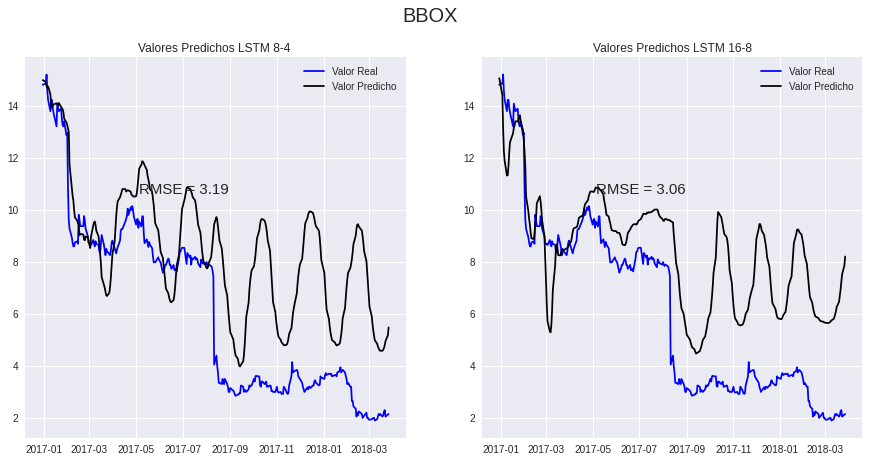

In [17]:
fig, axes = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la LSTM 10-5
axes[0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0].plot(index_time_t,predictedLSTM105, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos LSTM 8-4 ')
axes[0].annotate('RMSE = %.2f'% rmseLSTM105, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos LSTM 16-8')
axes[1].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)




plt.show()

Basandonos en los errores de entrenamiento decido que el mejor modelo para el activo MINI es el que tenga menor error, en este caso es el modelo de 16-8

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [30]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedLSTM168

# Es un margen movil, segun lo que busquemos
margen = 0.03
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 213, -1.0: 54, 1.0: 42})


In [31]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26    0.510616    32451      0  2.125  7.86708   1
Valor Final = 68958.89
Ganancia con margen = -31041.11


In [22]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2016-12-30      100000        0      0  14.8271  15.0765  NaN
2017-01-03      100000        0      0  14.8757  14.4251   -1
2017-01-04      100000        0      0   15.216  13.1607   -1
2017-01-05      100000        0      0   14.584  12.2657   -1
2017-01-06      100000        0      0  14.2437  11.8985   -1
2017-01-09     1.48789     7243      1  13.8062  11.3302    1
2017-01-10     1.48789     7243      0  14.2437  11.3386    1
2017-01-11     1.48789     7243      0  14.2437   11.689    1
2017-01-12     1.48789     7243      0  13.9521  12.2178    1
2017-01-13     1.48789     7243      0  13.7576  12.6154    1
2017-01-17     1.48789     7243      0  13.2229  12.9556    1
2017-01-18     1.48789     7243      0  14.0979  13.1689    1
2017-01-19     1.48789     7243      0  13.9521    13.26    1
2017-01-20      100000        0     -1  13.8062  13.4212   -1
2017-01-23     6.34924     7192      1  13.9035  13.4053    1
2017-01-

In [32]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/BBOX/Alza3LSTM252-168.csv")

In [33]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26    0.947712    59710             0      0  2.125  7.86708   1
Valor Final = 126884.70
Ganancia con margen = 26884.70


In [26]:
print(movimientos_ab)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30     5.96033     6744             0      0  14.8271  15.0765  NaN
2017-01-03      200650        0          6744     -1  14.8757  14.4251   -1
2017-01-04      200650        0          6744      0   15.216  13.1607   -1
2017-01-05      200650        0          6744      0   14.584  12.2657   -1
2017-01-06      200650        0          6744      0  14.2437  11.8985   -1
2017-01-09     3.82134     7789             0      1  13.8062  11.3302    1
2017-01-10     3.82134     7789             0      0  14.2437  11.3386    1
2017-01-11     3.82134     7789             0      0  14.2437   11.689    1
2017-01-12     3.82134     7789             0      0  13.9521  12.2178    1
2017-01-13     3.82134     7789             0      0  13.7576  12.6154    1
2017-01-17     3.82134     7789             0      0  13.2229  12.9556    1
2017-01-18     3.82134     7789             0      0  14.0979  13.1689    1
2017-01-19  

In [34]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/BBOX/AlzaBaja3LSTM252-168.csv")

In [35]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      183404        0             0      1  2.125  7.86708   1
Valor Final = 183403.67
Ganancia con margen = 83403.67


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [36]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/BBOX/Baja3LSTM252-168.csv")